# Deep Learning Course: Final Project


Submitted by:

Meir Goldenberg 034810325

Almog Hadad 208744466

##**Assignment Instruction:**

Design compression method combining lottery ticket hypothesis and ALDS (implemented
in torchprune)


In [ ]:
%matplotlib inline

#importing TorchProne package (MIT License)

In [ ]:
!git clone https://github.com/AlmogHadad/torchprune

Cloning into 'torchprune'...
remote: Enumerating objects: 1138, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 1138 (delta 74), reused 43 (delta 43), pack-reused 1031
Receiving objects: 100% (1138/1138), 6.74 MiB | 27.83 MiB/s, done.
Resolving deltas: 100% (528/528), done.


In [ ]:
!pip install -r /content/torchprune/misc/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
Obtaining file:///content/torchprune/src/torchprune (from -r /content/torchprune/misc/requirements.txt (line 2))
  Preparing metadata (setup.py) ... done
Obtaining file:///content/torchprune/src/experiment (from -r /content/torchprune/misc/requirements.txt (line 3))
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.2/202.2 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!python /content/torchprune/src/torchprune/setup.py install

/usr/lib/python3.8/distutils/dist.py:259: UserWarning: 'licence' distribution option is deprecated; use 'license'
  warnings.warn(msg)
running install
running bdist_egg
running egg_info
creating torchprune.egg-info
writing torchprune.egg-info/PKG-INFO
writing dependency_links to torchprune.egg-info/dependency_links.txt
writing requirements to torchprune.egg-info/requires.txt
writing top-level names to torchprune.egg-info/top_level.txt
writing manifest file 'torchprune.egg-info/SOURCES.txt'
reading manifest file 'torchprune.egg-info/SOURCES.txt'
writing manifest file 'torchprune.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying torchprune.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying torchprune.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying torchprune.egg-

#imports

In [ ]:
# import the required packages
import os, sys
sys.path.append(os.getcwd())
import os
import copy
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.optim import lr_scheduler
import numpy as np
import shutil
import torchprune.src.torchprune.torchprune as tp
import torch.optim as optim
from google.colab import runtime


#Globals

In [ ]:
number_of_epochs_training = 25         # number of training epochs (30 optimal)
number_of_epochs_retraining = 25       # number of retraining epochs 
imp_fine_tuning_number_of_epochs = 25  # number of  epochs for training after IMP
keep_ratio = 0.5                       # Ratio of parameters to keep for ALDS
imp_percentage_increase = 0.05         # the increase in IMP prunning for each iteration
imp_prune_percentage = 0.4             # the IMP percentage to begin with
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#ALDS parameters

In [ ]:
# %% Setup some stats to track results and retrieve checkpoints
n_idx = 0  # network index 0

s_idx = 0  # keep ratio's index
r_idx = 0  # repetition index

# %% initialize data loaders with a limited number of points
transform_train = [
    torchvision.transforms.Pad(4),
    torchvision.transforms.RandomCrop(32),
    torchvision.transforms.RandomHorizontalFlip(),
]
transform_static = [
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    ),
]


testset = torchvision.datasets.CIFAR10(
    root="./local",
    train=False,
    download=True,
    transform=tp.util.transforms.SmartCompose(transform_static),
)

trainset = torchvision.datasets.CIFAR10(
    root="./local",
    train=True,
    download=True,
    transform=tp.util.transforms.SmartCompose(
        transform_train + transform_static
    ),
)

size_s = 128
batch_size = 128
testset, set_s = torch.utils.data.random_split(
    testset, [len(testset) - size_s, size_s]
)

loader_s = torch.utils.data.DataLoader(set_s, batch_size=32, shuffle=False)
loader_test = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False
)
loader_train = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=False
)

# %% Setup trainer
# Set up training parameters
train_params = {
    # any loss and corresponding kwargs for __init__ from tp.util.nn_loss
    "loss": "CrossEntropyLoss",
    "lossKwargs": {"reduction": "mean"},
    # exactly two metrics with __init__ kwargs from tp.util.metrics
    "metricsTest": [
        {"type": "TopK", "kwargs": {"topk": 1}},
        {"type": "TopK", "kwargs": {"topk": 5}},
    ],
    # any optimizer from torch.optim with corresponding __init__ kwargs
    "optimizer": "SGD",
    "optimizerKwargs": {
        "lr": 0.1,
        "weight_decay": 1.0e-4,
        "nesterov": False,
        "momentum": 0.9,
    },
    # batch size
    "batchSize": batch_size,
    # desired number of epochs
    "startEpoch": 0,    
    "retrainStartEpoch": -1,
    "numEpochs": number_of_epochs_training,
    "earlyStopEpoch": 1,
    # any desired combination of lr schedulers from tp.util.lr_scheduler
    "lrSchedulers": [
        {
            "type": "MultiStepLR",
            "stepKwargs": {"milestones": [91, 136]},
            "kwargs": {"gamma": 0.1},
        },
        {"type": "WarmupLR", "stepKwargs": {"warmup_epoch": 5}, "kwargs": {}},
    ],
    "enableAMP": False,
    # output size of the network
    "outputSize": 10,
    # directory to store checkpoints
    "dir": os.path.realpath("./checkpoints"),
}

# Setup retraining parameters (just copy train-parameters)
retrain_params = copy.deepcopy(train_params)
retrain_params["numEpochs"] = number_of_epochs_retraining

AttributeError: ignored

#IMP - iterative magnitude prunning

In [ ]:
def imp(net_to_prune, prune_percentage):    
    print("imp target percentage to prune: ", prune_percentage)

    try:
      total_weights = net_to_prune.size()
    except:
      total_weights = sum(p.numel() for p in net_to_prune.parameters())        
    all_tensors = torch.cat([param.flatten() for param in list(net_to_prune.parameters())])
    all_tensors = torch.abs(all_tensors)
    sorted, _ = torch.sort(all_tensors)
    prune_max_val_index = int(total_weights * prune_percentage) 
    prune_max_val = sorted[prune_max_val_index]
    prune_max_val = prune_max_val.item()  
    #print("prune_max_val: ", prune_max_val)  
    
    mask_list = []
    for param in net_to_prune.parameters():           
        mask = (torch.abs(param)>prune_max_val)        
        mask_list.append(mask)
   
    return mask_list

# our model

In [ ]:
class Net_With_BN_Dropout(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),            
            nn.ReLU(),            
            nn.MaxPool2d(2),   
            nn.Dropout(0.2),         
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),            
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),   
            nn.ReLU(),                    
            nn.MaxPool2d(2),        
            nn.Dropout(0.2),             
            nn.Conv2d(64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),                    
            nn.Conv2d(128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),            
            nn.MaxPool2d(2),        
            nn.Dropout(0.2)                            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),          
            nn.Linear(2048, 512),            
            nn.ReLU(),
            nn.Linear(512, 256),                       
            nn.ReLU(),
            nn.Linear(256, 10),               
        )
    def forward(self, x):
        features = self.feature_extractor(x)
        class_scores = self.classifier(features)
        return class_scores

#calculating accuracy and plotting

In [ ]:
from sklearn.metrics import top_k_accuracy_score
import torch.optim as optim
import numpy as np


def plot_graph(title, x_label, y_label, val_list, label_list, early_stopping=0, x_axis=0):
    plt.cla()
    
    for values, label in zip(val_list, label_list):
      plt.plot(range(len(values)), values, label=label)    
    if x_axis != 0:
      default_x_ticks = range(len(x_axis))
      plt.xticks(default_x_ticks, x_axis)

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    if early_stopping != 0:
      plt.axvline(x = early_stopping, color = 'b', label = 'early stopping')
    
    plt.legend()
    plt.show()
    return

def calculate_acc(dataset_loader, model):
    n_correct = 0
    n_total = 0
    compressed_model = model        

    if hasattr(model, "compressed_net"):
      compressed_model = model.compressed_net

    for j,(data, label) in enumerate(dataset_loader):
        data = data.to(device)
        label = label.to(device)
        # calculate output
        y_hat = model(data)
        # for fully convolutional where size needs to be reduced to 2 dimensions
        if len(list(y_hat.size())) > 2:
          y_hat = torch.squeeze(y_hat)
        # get the prediction
        predictions = torch.argmax(y_hat, dim=1)
        n_correct += torch.sum(predictions == label.to(device)).type(torch.float64)
        n_total += data.shape[0]
    acc = (n_correct / n_total).item()
    return acc

#Custom training function

In [ ]:
from sklearn.metrics import top_k_accuracy_score
import torch.optim as optim
import numpy as np

def train_model_custom(epochs, model, optimizer, scheduler, imp_mask_list):    
    ce_loss = torch.nn.CrossEntropyLoss()

    top1 = []
    top5 = []
    train_acc = []
    val_acc = []
    test_acc = []
    loss_list = []
    loss_val_list = []
    best_result = 0
    full_patience = 15
    patience = full_patience
    epoch_stopped = 0
    best_model = None
    compressed_model = model        

    if hasattr(model, "compressed_net"):
      compressed_model = model.compressed_net
      model.register_sparsity_pattern()        
        
    for i in range(epochs):        
        model_label = []        
        train_loss_list = []
        validation_loss_list = []

        for data, label in loader_train:
            optimizer.zero_grad()
            label_cpu = label
            
            data = data.to(device)
            label = label.to(device)           
            # calculate output
            y_hat = compressed_model(data)
            # for fully convolutional where size needs to be reduced to 2 dimensions
            if len(list(y_hat.size())) > 2:
              y_hat = torch.squeeze(y_hat)
            # calculate loss
            loss = ce_loss(y_hat, label)
            loss.backward()
            optimizer.step()
            for param, mask in zip(model.parameters(), imp_mask_list):            
             param.data = param.data * mask           
            train_loss_list.append(loss.detach())
        
        scheduler.step()
        true_label = []
        rest_of_true_label = []
        # to calculate the val loss
        # with torch.no_grad():
        for data, label in loader_s:
            
            data = data.to(device)
            label = label.to(device)

            # calculate output
            y_hat = compressed_model(data)            
            # for fully convolutional where size needs to be reduced to 2 dimensions
            if len(list(y_hat.size())) > 2:
              y_hat = torch.squeeze(y_hat)
            y_hat_cpu = y_hat.to("cpu")
            # calculate loss
            loss = ce_loss(y_hat, label)
            validation_loss_list.append(loss.detach())
            
            if len(label.tolist()) == batch_size:
              true_label.append(label.tolist())
            else:
              rest_of_true_label.append(label.tolist())
            for k in y_hat_cpu:
                model_label.append(k.tolist())

        train_accuracy = calculate_acc(loader_train, model)
        val_accuracy = calculate_acc(loader_s, model)
        test_accuracy = calculate_acc(loader_test, model)

        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)
        test_acc.append(test_accuracy)
                
        true_label = np.array(true_label).flatten()
        for k in rest_of_true_label:
          true_label = np.insert(true_label, len(true_label), k)
        model_label = np.array(model_label)

        labels = np.arange(10)        
        top_1 = top_k_accuracy_score(true_label, model_label, k=1, labels=labels)
        top_5 = top_k_accuracy_score(true_label, model_label, k=5, labels=labels)
        top1.append(top_1)
        top5.append(top_5)

        if patience > 0:
          patience, best_model, epoch_stopped, best_result  = (full_patience, model, i, top_1) if top_1 > best_result else (patience-1, best_model, epoch_stopped, best_result)

        stats = "epoch {} | train loss : {} | validiation loss : {} | train accuracy: {} | validiation accuracy: {} |  top 1: {} | top 5: {}".format(i, torch.mean(torch.tensor(train_loss_list)), torch.mean(torch.tensor(validation_loss_list)), train_accuracy, val_accuracy, top_1, top_5)
        print(stats)
        loss_list.append(torch.mean(torch.tensor(train_loss_list)))
        loss_val_list.append(torch.mean(torch.tensor(validation_loss_list)))

    # plot top K and Loss graphs
    plot_graph("Top K", 'Epochs', 'Accuracy', [top1, top5], ['Top 1', 'Top 5'], early_stopping=0)
    plot_graph("Loss", 'Epochs', 'Loss Values', [loss_list, loss_val_list], ['Train Loss', 'Validation Loss'], early_stopping=0)

    # the ALDS model has the .size() function
    # but the original model doesn't
    # For the "IMP-only" model, use the explicit weight calculation
    try:
      total_weights = model.size()
    except:
      total_weights = sum(p.numel() for p in model.parameters())     

    all_tensors = torch.cat([param.flatten() for param in list(model.parameters())])
    count = torch.numel(all_tensors[all_tensors == False])
    print("\ntotal weights: {} weights zeroed: {} in percentage: {:.5f}\n".format(total_weights, count, count/total_weights ))
    
    return train_acc, val_acc, test_acc, epoch_stopped, best_model

def run_custom_train(model, imp_mask_list):
    custom_optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1.0e-4, nesterov=False)
    custom_exp_lr_scheduler = optim.lr_scheduler.StepLR(custom_optimizer, step_size=8, gamma=0.1)
    train_acc_list, val_acc_list, test_acc_list, epoch_stopped, best_model = train_model_custom(imp_fine_tuning_number_of_epochs, model, custom_optimizer, custom_exp_lr_scheduler, imp_mask_list)
    return train_acc_list, val_acc_list, test_acc_list, epoch_stopped, best_model


#Running IMP with ALDS

Performing initial model training
Training Progress: Epoch [ 1/25] | Step [  0/391] | Loss: 2.284866 | Top1: 11.72% | Top5: 56.25% | Elapsed Time: 7.40s
Training Progress: Epoch [ 1/25] | Step [ 39/391] | Loss: 2.277067 | Top1: 10.16% | Top5: 58.59% | Elapsed Time: 2.09s
Training Progress: Epoch [ 1/25] | Step [ 78/391] | Loss: 2.114973 | Top1: 22.66% | Top5: 78.91% | Elapsed Time: 2.03s
Training Progress: Epoch [ 1/25] | Step [117/391] | Loss: 1.839837 | Top1: 32.03% | Top5: 89.06% | Elapsed Time: 2.49s
Training Progress: Epoch [ 1/25] | Step [156/391] | Loss: 1.726593 | Top1: 30.47% | Top5: 92.19% | Elapsed Time: 3.23s
Training Progress: Epoch [ 1/25] | Step [195/391] | Loss: 1.672646 | Top1: 35.94% | Top5: 91.41% | Elapsed Time: 2.27s
Training Progress: Epoch [ 1/25] | Step [234/391] | Loss: 1.700395 | Top1: 32.81% | Top5: 92.19% | Elapsed Time: 2.02s
Training Progress: Epoch [ 1/25] | Step [273/391] | Loss: 1.547769 | Top1: 44.53% | Top5: 91.41% | Elapsed Time: 1.99s
Training Progr

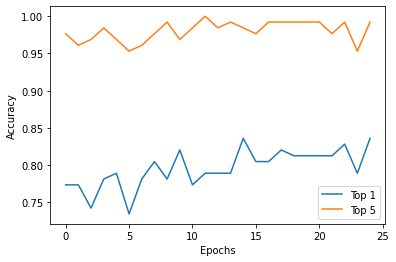

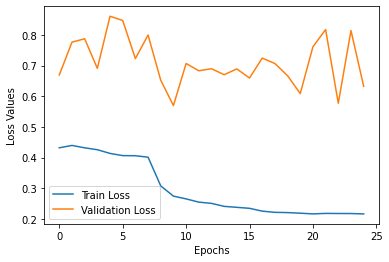


total weights: 1134246 weights zeroed: 588357 in percentage: 0.51872

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.864870340356564
End Of Iteration


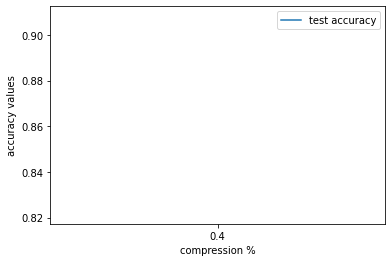

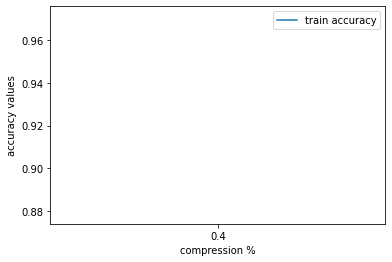

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

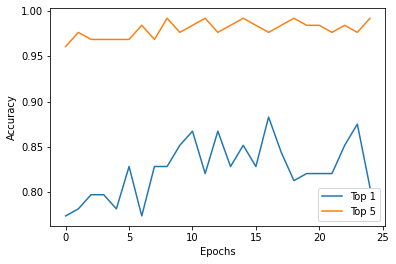

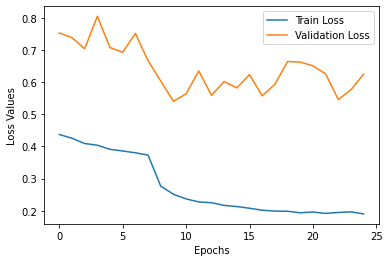


total weights: 1106972 weights zeroed: 661901 in percentage: 0.59794

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8613249594813613
End Of Iteration


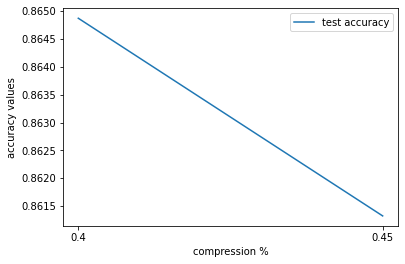

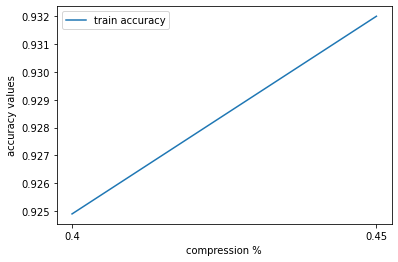

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

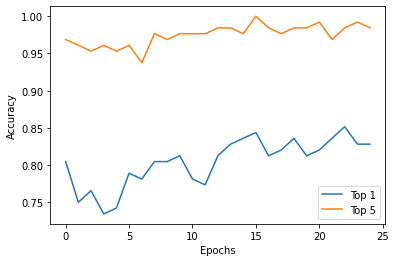

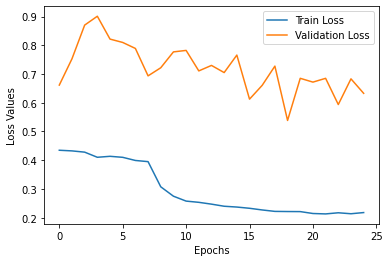


total weights: 1057870 weights zeroed: 735446 in percentage: 0.69521

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8655794165316045
End Of Iteration


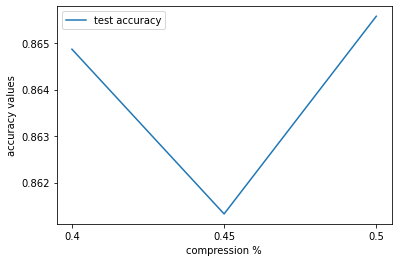

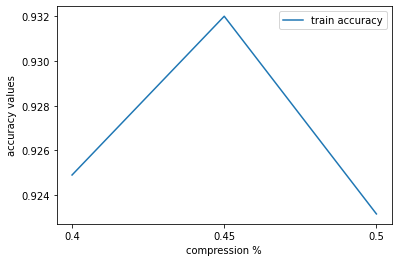

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

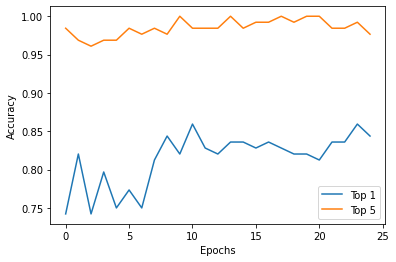

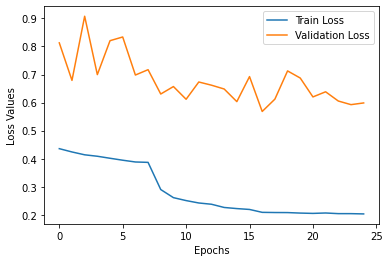


total weights: 1024673 weights zeroed: 808990 in percentage: 0.78951

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8667949756888168
End Of Iteration


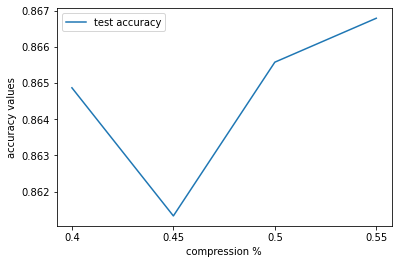

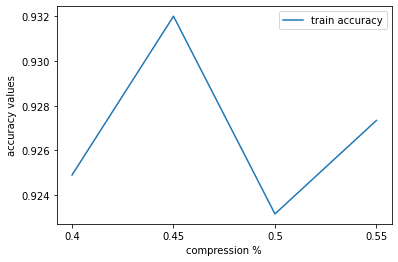

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

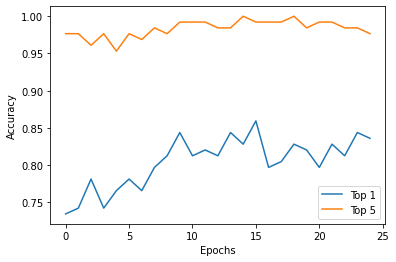

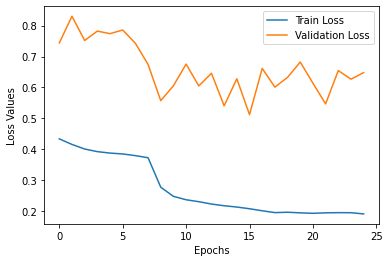


total weights: 1004941 weights zeroed: 882535 in percentage: 0.87820

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8685170178282009
End Of Iteration


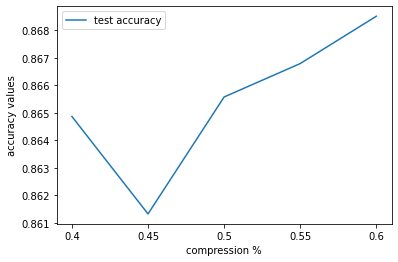

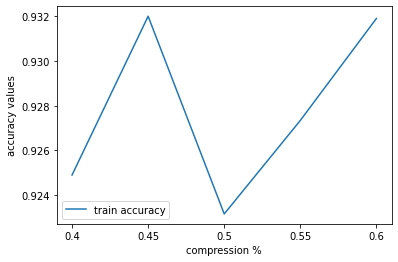

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

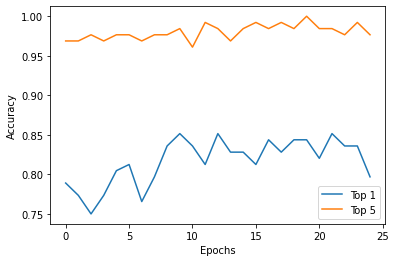

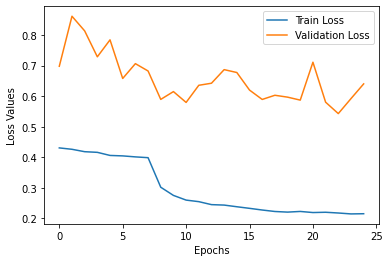


total weights: 950914 weights zeroed: 956079 in percentage: 1.00543

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.858691247974068
End Of Iteration


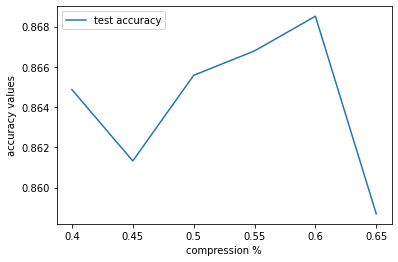

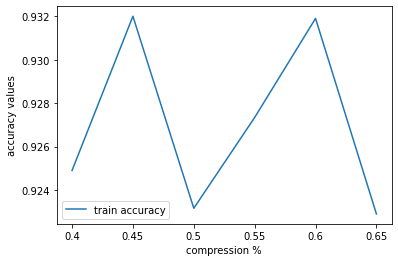

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

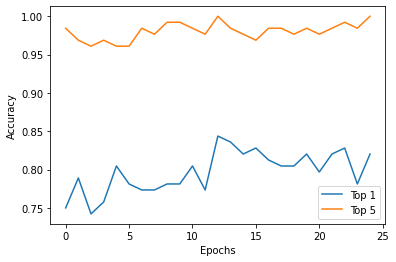

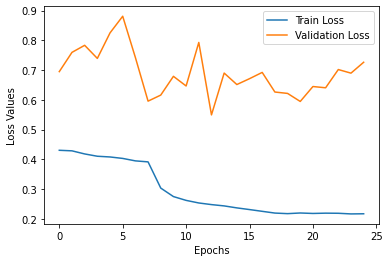


total weights: 911087 weights zeroed: 1029623 in percentage: 1.13010

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8628444084278768
End Of Iteration


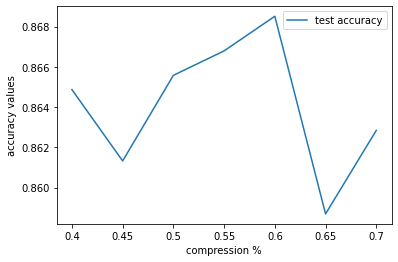

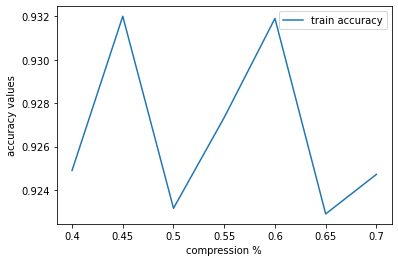

ALDS keep ratio:  0.5
Total time:  0.5s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.5s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

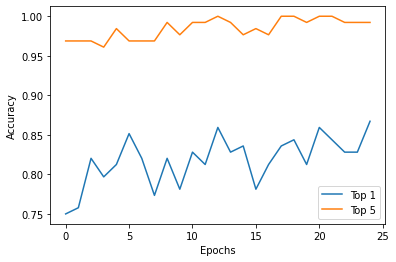

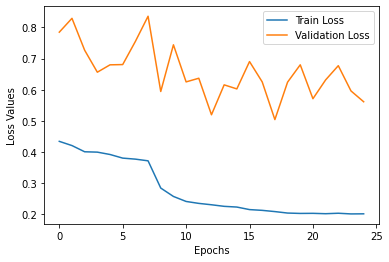


total weights: 883355 weights zeroed: 1103168 in percentage: 1.24884

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8632495948136142
End Of Iteration


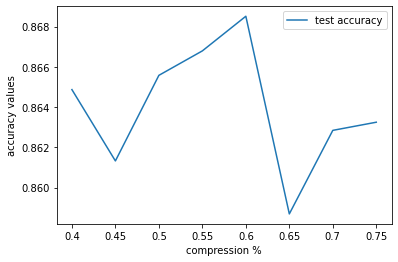

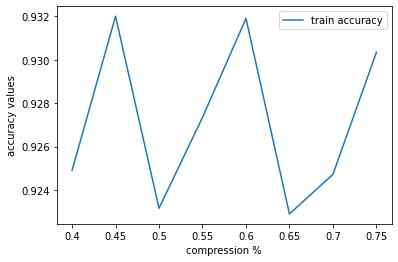

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

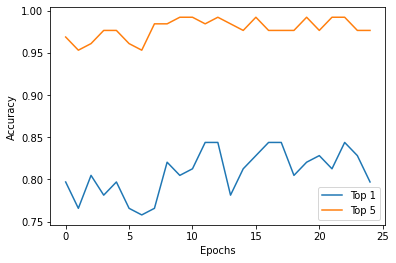

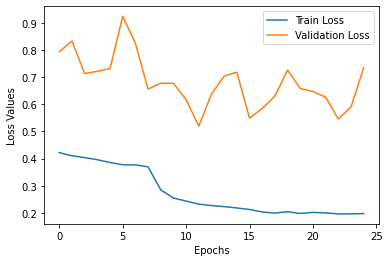


total weights: 849291 weights zeroed: 1176713 in percentage: 1.38552

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8611223662884927
End Of Iteration


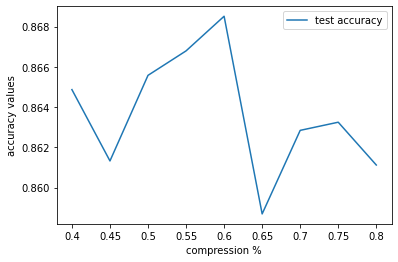

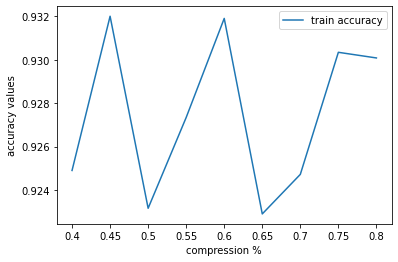

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

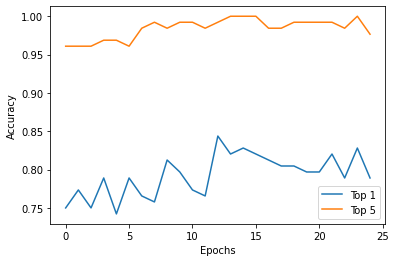

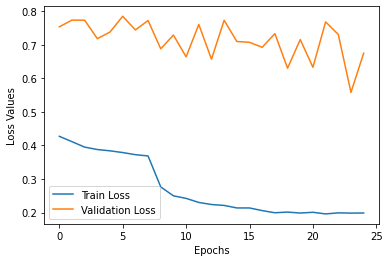


total weights: 813702 weights zeroed: 1250257 in percentage: 1.53650

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8672001620745543
End Of Iteration


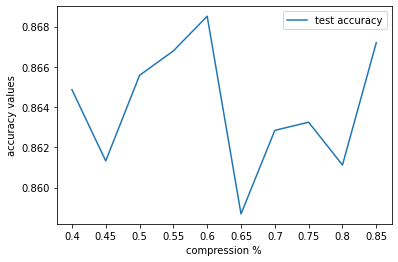

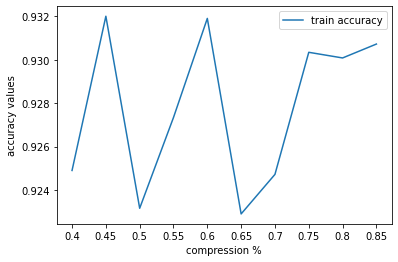

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

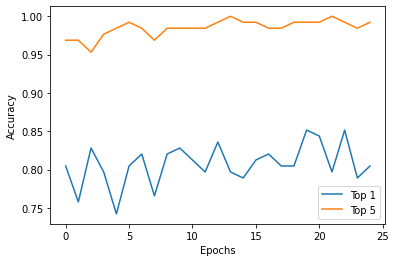

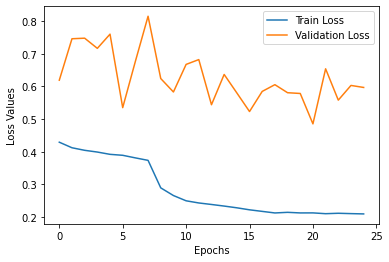


total weights: 763831 weights zeroed: 1323802 in percentage: 1.73311

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8664910858995137
End Of Iteration


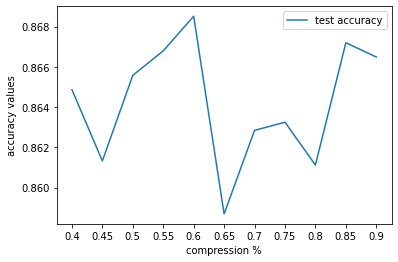

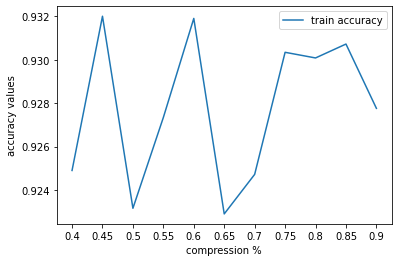

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

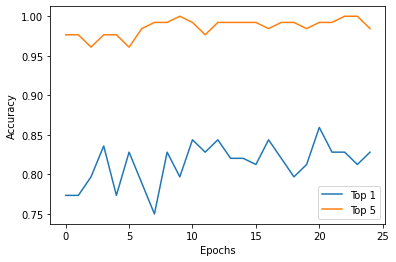

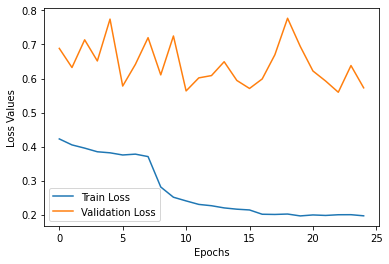


total weights: 767910 weights zeroed: 1338510 in percentage: 1.74306

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8668962722852511
End Of Iteration


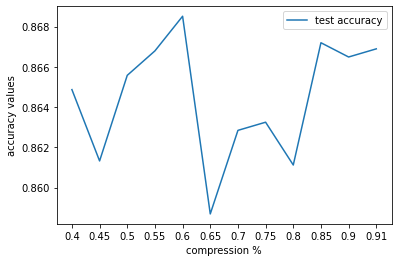

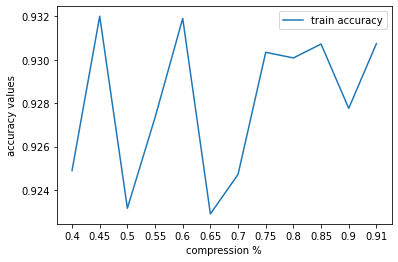

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

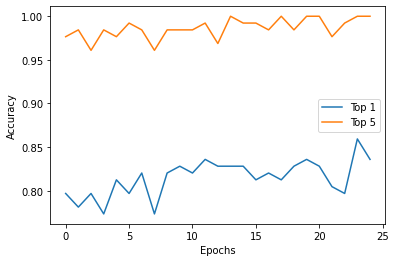

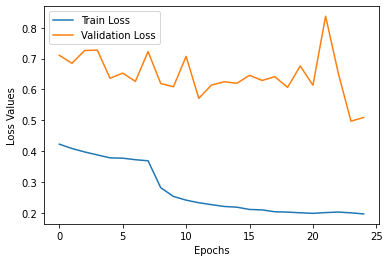


total weights: 755209 weights zeroed: 1353219 in percentage: 1.79185

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8645664505672609
End Of Iteration


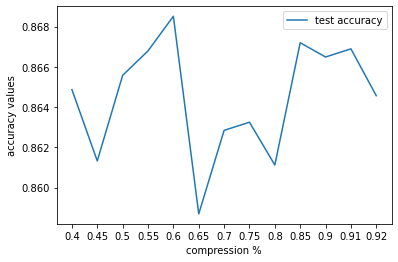

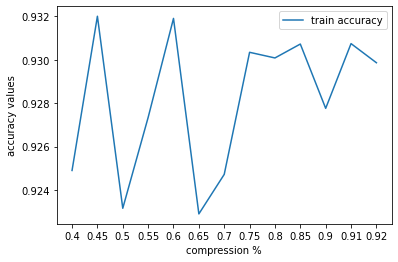

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

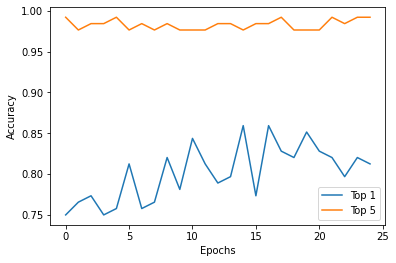

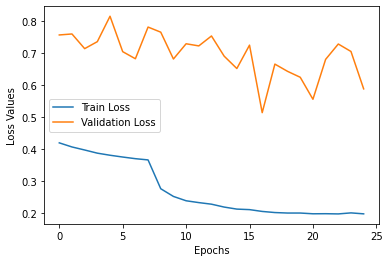


total weights: 751710 weights zeroed: 1367928 in percentage: 1.81975

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8603119935170178
End Of Iteration


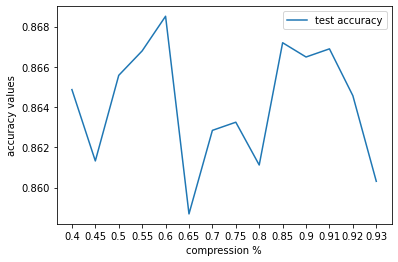

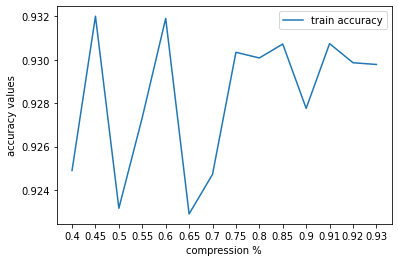

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

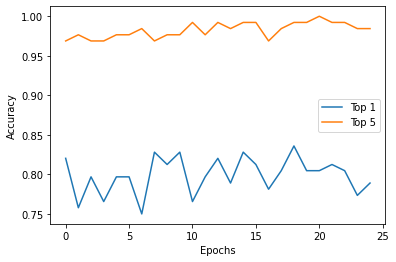

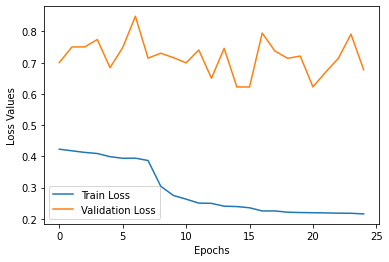


total weights: 731412 weights zeroed: 1382637 in percentage: 1.89037

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8616288492706644
End Of Iteration


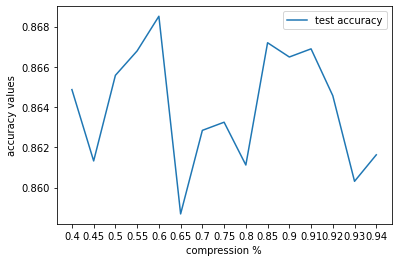

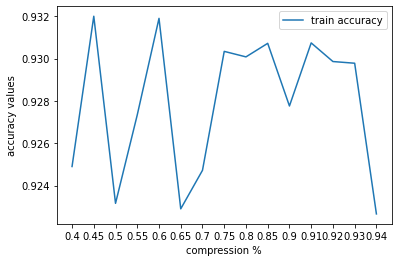

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

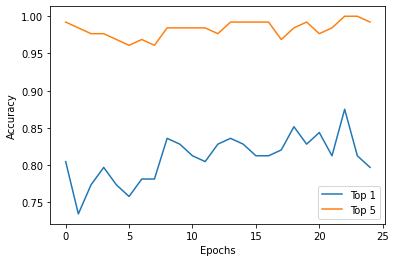

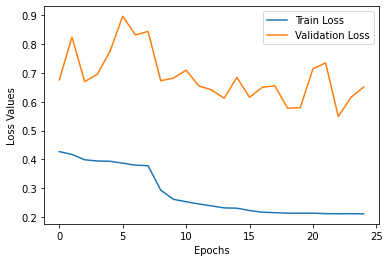


total weights: 726481 weights zeroed: 1397346 in percentage: 1.92344

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8661871961102107
End Of Iteration


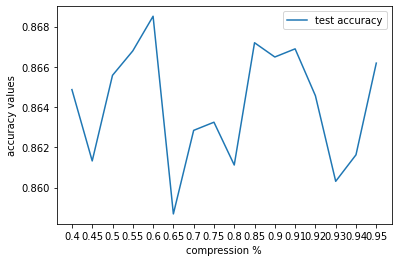

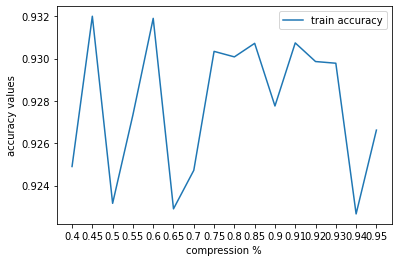

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

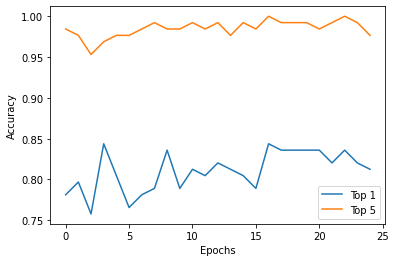

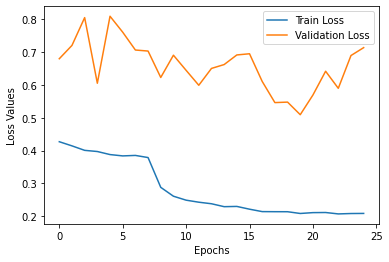


total weights: 719131 weights zeroed: 1412055 in percentage: 1.96356

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8655794165316045
End Of Iteration


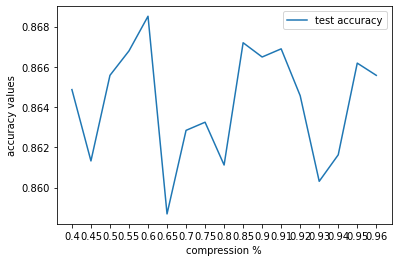

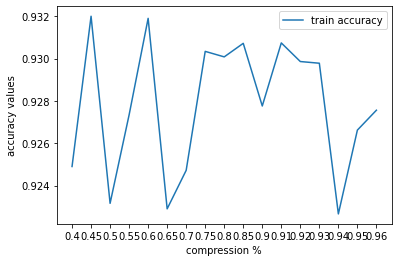

ALDS keep ratio:  0.5
Total time:  0.5s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

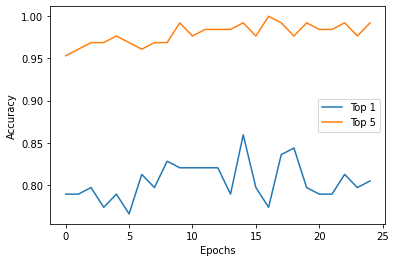

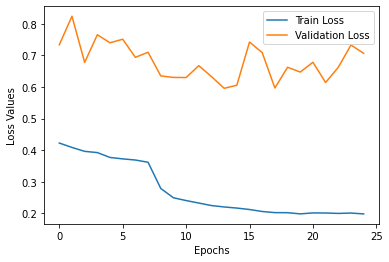


total weights: 718465 weights zeroed: 1426764 in percentage: 1.98585

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8605145867098865
End Of Iteration


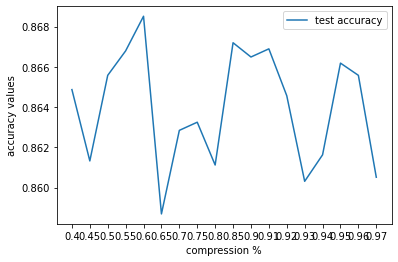

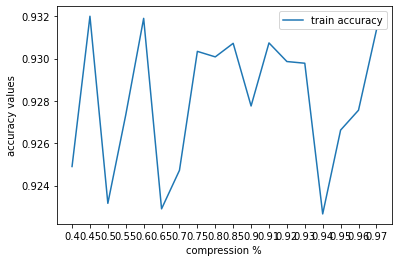

ALDS keep ratio:  0.5
Total time:  0.5s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.5s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

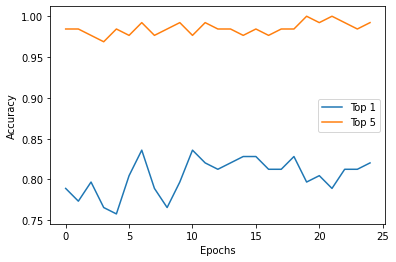

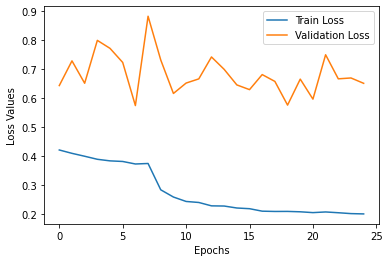


total weights: 708550 weights zeroed: 1441473 in percentage: 2.03440

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.8633508914100486
End Of Iteration


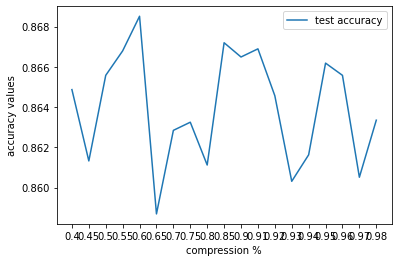

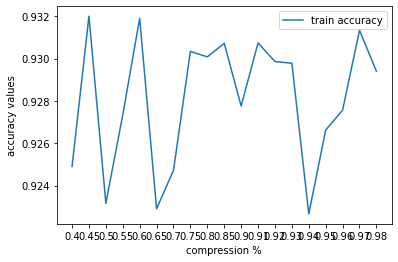

ALDS keep ratio:  0.5
Total time:  0.4s | Preprocessing time:  0.0s | Sparsifier instantiation time:  0.0s | Allocator instantiation time:  0.4s | Clean up time:  0.0s
Started seed 0 with relative error 0.12893827259540552
Seed 0, it 0: current relative error 0.11384514719247812
Seed 0, it 1: current relative error 0.11214050650596621
Seed 0, it 2: current relative error 0.11384514719247812
Seed 0, it 3: current relative error 0.11214050650596624
Seed 0: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 1 with relative error 0.12893827259540552
Seed 1, it 0: current relative error 0.11384514719247812
Seed 1, it 1: current relative error 0.11214050650596621
Seed 1, it 2: current relative error 0.11384514719247812
Seed 1, it 3: current relative error 0.11214050650596624
Seed 1: improved from 0.12893827259540552 to 0.11214050650596624
Started seed 2 with relative error 0.11724971979856486
Seed 2, it 0: current relative error 0.11214050650596619
Seed 2, it 1: current re

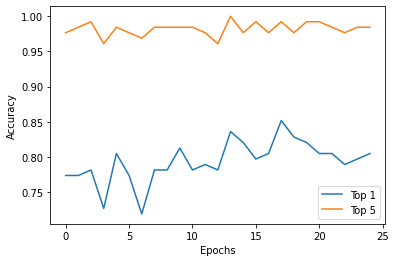

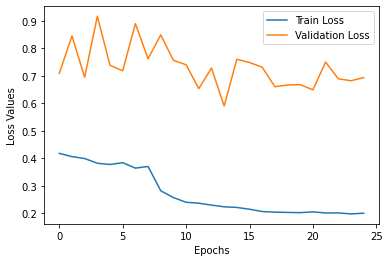


total weights: 706125 weights zeroed: 1456182 in percentage: 2.06222

test accuracy after ALDS after retrain and reconstruct (after IMP):  0.865174230145867
End Of Iteration


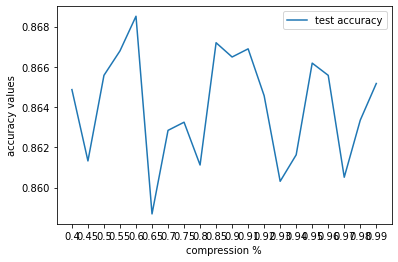

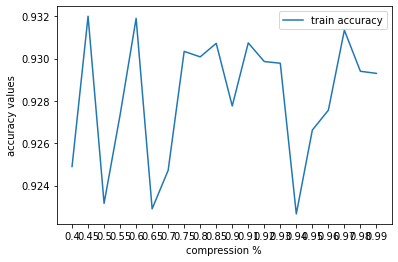

[0.864870340356564, 0.8613249594813613, 0.8655794165316045, 0.8667949756888168, 0.8685170178282009, 0.858691247974068, 0.8628444084278768, 0.8632495948136142, 0.8611223662884927, 0.8672001620745543, 0.8664910858995137, 0.8668962722852511, 0.8645664505672609, 0.8603119935170178, 0.8616288492706644, 0.8661871961102107, 0.8655794165316045, 0.8605145867098865, 0.8633508914100486, 0.865174230145867]
start time:  1676267699.8893154 end time:  1676304249.0673306 total time in minutes:  609.1529669205348


In [ ]:
import time

# %% initialize the network and wrap it into the NetHandle class
net_name = "CIFAR10_conv_nn"
net = Net_With_BN_Dropout(3).to(device)

loss_on_pruning = []

test_accuracy = []
train_accuracy = []
training_loss = []
prune_percent_list = []

# Setup trainer
trainer = tp.util.train.NetTrainer(
    train_params=train_params,
    retrain_params=retrain_params,
    train_loader=loader_train,
    test_loader=loader_test,
    valid_loader=loader_s,
    num_gpus=1,
)
    
# wrap net with netHandle
net = tp.util.net.NetHandle(net, net_name)

# remove training folder to prevent using old values
if os.path.exists(train_params['dir']):
  print("Removing data from: ", train_params['dir'])
  shutil.rmtree(train_params['dir'])

st = time.time()
# inital training
print("Performing initial model training")
trainer.train(net, n_idx)

# get a loss handle
loss_handle = trainer.get_loss_handle()    

print("\n===========================")
print("model statistics before pruning")
print(
    f"The network has {net.size()} parameters and "
    f"{net.flops()} FLOPs."
)
print("===========================\n")

# build ALDS network
net = tp.ALDSNet(net, loader_s, loss_handle)

print("test accuracy after inital training: ", calculate_acc(loader_test, net))

while imp_prune_percentage < 1:
    prune_percent_list.append(imp_prune_percentage)
    print("ALDS keep ratio: ", keep_ratio)
    # dummy forward action to overcome an ALDS issue
    net.forward(torch.rand(4, 3, 32, 32).to("cuda"))
    # compress the net
    net.compress(keep_ratio=keep_ratio)
    print("\n===========================")
    print(
        f"After compress, the network has {net.size()} parameters and "
        f"{net.flops()} FLOPs left. the keep ratio is {keep_ratio} and the real keep ratio is {net.size() / 1470890}"
    )
    print("===========================\n")

    print("test accuracy after ALDS compression before retrain: ", calculate_acc(loader_test, net))    
    
    trainer.retrain(net, n_idx, keep_ratio, s_idx, r_idx)

    print("test accuracy after ALDS compression retrain: ", calculate_acc(loader_test, net))
    s_idx += 1
    # reconstruct network 
    net._remove_projection()
    
    print("\n===========================")
    print(
        f"After reconstruct, the network has {net.size()} parameters and "
        f"{net.flops()} FLOPs."
    )
    print("===========================\n")
            
    print("Calculating Iterative Magnitude Prunning (IMP) masks")
    imp_mask_list = imp(net, imp_prune_percentage)     
    print("Retraining network after applying IMP masks")
    torch.set_grad_enabled(True) 
    torch.cuda.empty_cache() 
    net.train()
    train_acc_list, val_acc_list, test_acc_list, epoch_stopped, best_model = run_custom_train(net, imp_mask_list)         
    net = best_model    
    test_acc = calculate_acc(loader_test, net)
    test_accuracy.append(test_acc)
    train_acc = calculate_acc(loader_train, net)
    train_accuracy.append(train_acc)  
    print("test accuracy after ALDS after retrain and reconstruct (after IMP): ", test_acc)

    print("End Of Iteration")
    r_idx += 1
    # added here in order to display graphs even if program crashes due to internet connection
    plot_graph("test accuracy after IMP", 'compression %', 'accuracy values', [test_accuracy], ['test accuracy'], 0, prune_percent_list)
    plot_graph("train accuracy after IMP", 'compression %', 'accuracy values', [train_accuracy], ['train accuracy'], 0, prune_percent_list)
    # increase prune percentage for next round   
    if imp_prune_percentage < 0.9:
        imp_prune_percentage += imp_percentage_increase
    else:
        imp_prune_percentage += 0.01         
    imp_prune_percentage = round(imp_prune_percentage, 2)
    
print(test_accuracy)

et = time.time()
print("start time: ", st, "end time: ", et, "total time in minutes: ", (et-st)/60)
runtime.unassign()


Note that after completing this long run, we noticed an issue with our calculation of total weights and hence, in the percentage calculation when printing the below type of output:


total weights: 950914 weights zeroed: 956079 in percentage: 1.00543

The total weights should always be 1470890. The weight zeroed calculation is correct and there is no impact on results of this test. It is just an error in the print statement.


#Model with IMP only

start inital training
epoch 0 | train loss : 1.6639539003372192 | validiation loss : 1.1606265306472778 | train accuracy: 0.49632000000000004 | validiation accuracy: 0.53125 |  top 1: 0.5625 | top 5: 0.9765625
epoch 1 | train loss : 1.2341090440750122 | validiation loss : 0.920836329460144 | train accuracy: 0.60262 | validiation accuracy: 0.6640625 |  top 1: 0.671875 | top 5: 0.953125
epoch 2 | train loss : 1.032036542892456 | validiation loss : 0.7390737533569336 | train accuracy: 0.6728200000000001 | validiation accuracy: 0.765625 |  top 1: 0.7109375 | top 5: 0.984375
epoch 3 | train loss : 0.9214363694190979 | validiation loss : 0.7146899700164795 | train accuracy: 0.69608 | validiation accuracy: 0.7578125 |  top 1: 0.75 | top 5: 1.0
epoch 4 | train loss : 0.8317156434059143 | validiation loss : 0.7451143860816956 | train accuracy: 0.7248600000000001 | validiation accuracy: 0.7578125 |  top 1: 0.7265625 | top 5: 0.9765625
epoch 5 | train loss : 0.7644562125205994 | validiation loss 

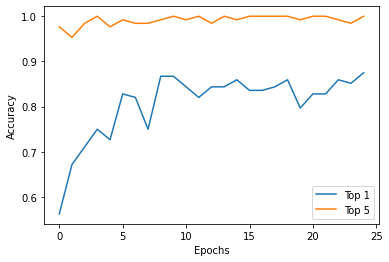

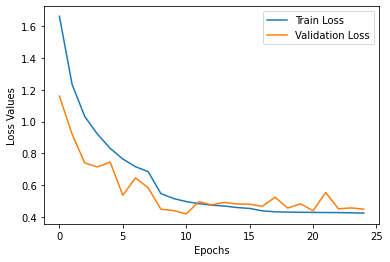


total weights: 1470890 weights zeroed: 0 in percentage: 0.00000

validation accuracy after inital training:  0.8122974068071313
percentage of pruning in this iteration is:  0.4
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.4
Retraining network after applying IMP masks
epoch 0 | train loss : 0.6090639233589172 | validiation loss : 0.559184730052948 | train accuracy: 0.79932 | validiation accuracy: 0.8203125 |  top 1: 0.8203125 | top 5: 0.9921875
epoch 1 | train loss : 0.5987207889556885 | validiation loss : 0.5167912244796753 | train accuracy: 0.80466 | validiation accuracy: 0.8671875 |  top 1: 0.8515625 | top 5: 0.9921875
epoch 2 | train loss : 0.5847320556640625 | validiation loss : 0.5697758197784424 | train accuracy: 0.7958400000000001 | validiation accuracy: 0.828125 |  top 1: 0.8046875 | top 5: 0.9921875
epoch 3 | train loss : 0.5723615884780884 | validiation loss : 0.6524261832237244 | train accuracy: 0.81386 | validiation accuracy: 0.83

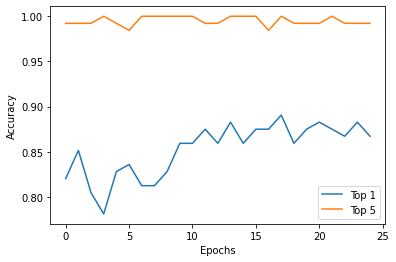

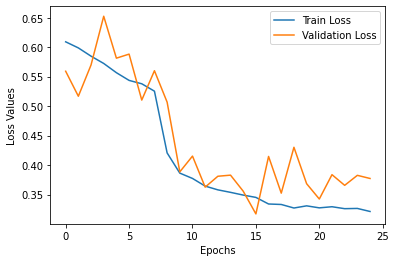


total weights: 1470890 weights zeroed: 588357 in percentage: 0.40000

Test accuracy after IMP:  0.8345826580226904
End Of Iteration


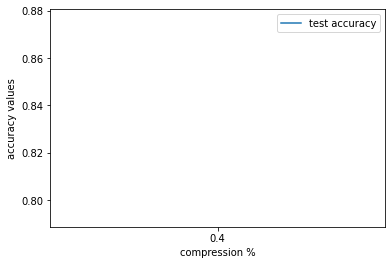

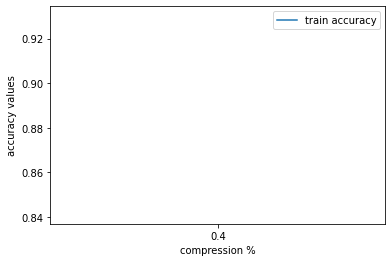

percentage of pruning in this iteration is:  0.45
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.45
Retraining network after applying IMP masks
epoch 0 | train loss : 0.48677268624305725 | validiation loss : 0.4653301239013672 | train accuracy: 0.83142 | validiation accuracy: 0.8203125 |  top 1: 0.8515625 | top 5: 1.0
epoch 1 | train loss : 0.48906612396240234 | validiation loss : 0.39967137575149536 | train accuracy: 0.8305400000000001 | validiation accuracy: 0.859375 |  top 1: 0.8828125 | top 5: 0.9921875
epoch 2 | train loss : 0.490631103515625 | validiation loss : 0.4111538827419281 | train accuracy: 0.8420000000000001 | validiation accuracy: 0.8828125 |  top 1: 0.84375 | top 5: 0.9921875
epoch 3 | train loss : 0.49071142077445984 | validiation loss : 0.5281883478164673 | train accuracy: 0.8439200000000001 | validiation accuracy: 0.8515625 |  top 1: 0.828125 | top 5: 1.0
epoch 4 | train loss : 0.476805716753006 | validiation loss : 0.5217921

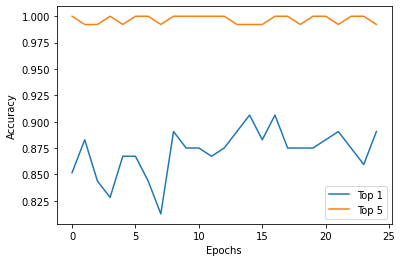

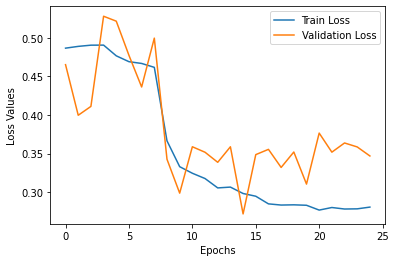


total weights: 1470890 weights zeroed: 661901 in percentage: 0.45000

Test accuracy after IMP:  0.8494732576985413
End Of Iteration


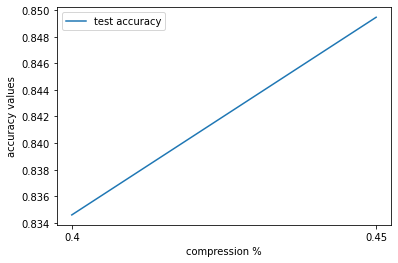

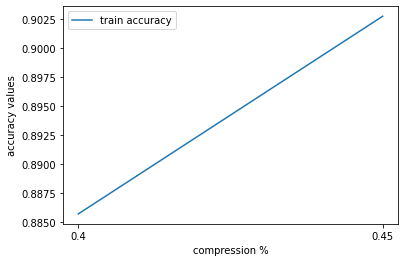

percentage of pruning in this iteration is:  0.5
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.5
Retraining network after applying IMP masks
epoch 0 | train loss : 0.42975929379463196 | validiation loss : 0.36837121844291687 | train accuracy: 0.85506 | validiation accuracy: 0.8671875 |  top 1: 0.8828125 | top 5: 1.0
epoch 1 | train loss : 0.44536229968070984 | validiation loss : 0.45134007930755615 | train accuracy: 0.8552400000000001 | validiation accuracy: 0.828125 |  top 1: 0.84375 | top 5: 0.9921875
epoch 2 | train loss : 0.443694144487381 | validiation loss : 0.3712538480758667 | train accuracy: 0.8547600000000001 | validiation accuracy: 0.84375 |  top 1: 0.8984375 | top 5: 0.9921875
epoch 3 | train loss : 0.43439796566963196 | validiation loss : 0.4926629960536957 | train accuracy: 0.85696 | validiation accuracy: 0.890625 |  top 1: 0.84375 | top 5: 0.984375
epoch 4 | train loss : 0.43159985542297363 | validiation loss : 0.4946974813938141

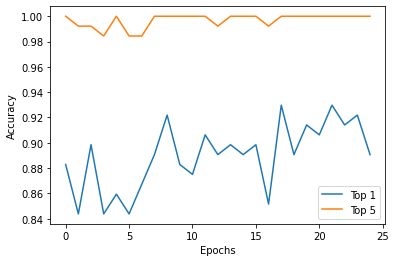

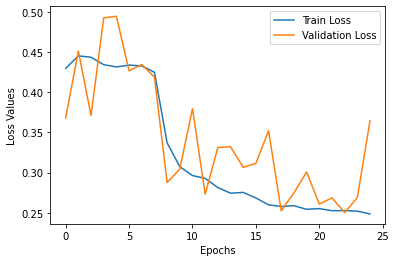


total weights: 1470890 weights zeroed: 735446 in percentage: 0.50000

Test accuracy after IMP:  0.8503849270664505
End Of Iteration


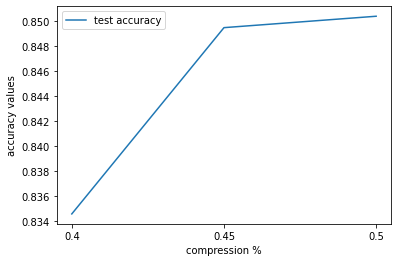

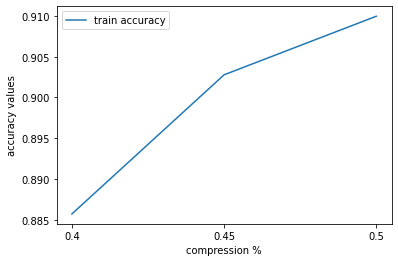

percentage of pruning in this iteration is:  0.55
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.55
Retraining network after applying IMP masks
epoch 0 | train loss : 0.3977823555469513 | validiation loss : 0.3862648010253906 | train accuracy: 0.86604 | validiation accuracy: 0.8828125 |  top 1: 0.8671875 | top 5: 0.984375
epoch 1 | train loss : 0.41852080821990967 | validiation loss : 0.4485164284706116 | train accuracy: 0.8615600000000001 | validiation accuracy: 0.8359375 |  top 1: 0.8359375 | top 5: 0.9921875
epoch 2 | train loss : 0.41246235370635986 | validiation loss : 0.4675584137439728 | train accuracy: 0.8523600000000001 | validiation accuracy: 0.84375 |  top 1: 0.875 | top 5: 0.984375
epoch 3 | train loss : 0.4105975329875946 | validiation loss : 0.39624473452568054 | train accuracy: 0.8591200000000001 | validiation accuracy: 0.859375 |  top 1: 0.859375 | top 5: 1.0
epoch 4 | train loss : 0.41244640946388245 | validiation loss : 0.38953

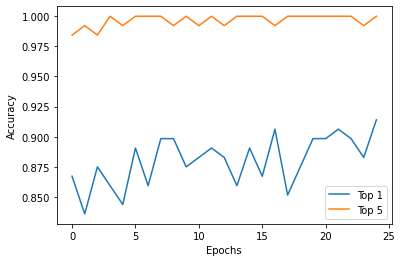

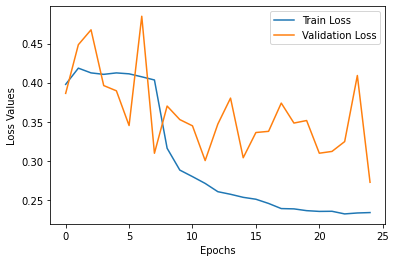


total weights: 1470890 weights zeroed: 808990 in percentage: 0.55000

Test accuracy after IMP:  0.8565640194489464
End Of Iteration


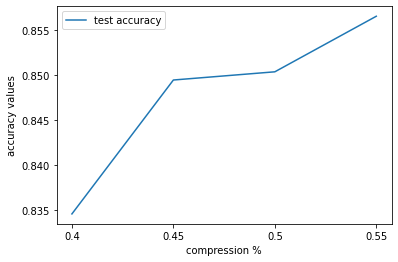

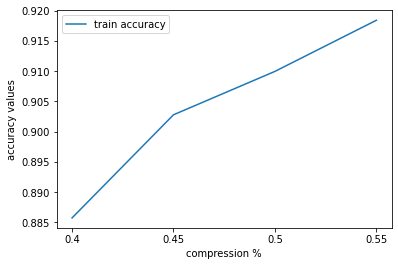

percentage of pruning in this iteration is:  0.6
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.6
Retraining network after applying IMP masks
epoch 0 | train loss : 0.37654200196266174 | validiation loss : 0.48404714465141296 | train accuracy: 0.8655200000000001 | validiation accuracy: 0.8515625 |  top 1: 0.84375 | top 5: 0.9765625
epoch 1 | train loss : 0.3962194621562958 | validiation loss : 0.40374597907066345 | train accuracy: 0.8721200000000001 | validiation accuracy: 0.859375 |  top 1: 0.8828125 | top 5: 1.0
epoch 2 | train loss : 0.39630722999572754 | validiation loss : 0.44691556692123413 | train accuracy: 0.8663400000000001 | validiation accuracy: 0.8671875 |  top 1: 0.859375 | top 5: 1.0
epoch 3 | train loss : 0.3900258243083954 | validiation loss : 0.4807654917240143 | train accuracy: 0.8680200000000001 | validiation accuracy: 0.8671875 |  top 1: 0.84375 | top 5: 0.9921875
epoch 4 | train loss : 0.3911212384700775 | validiation loss :

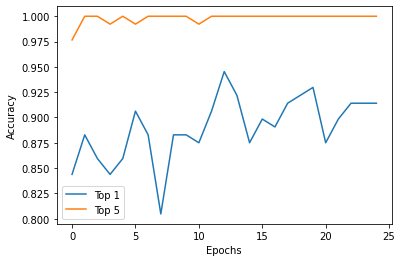

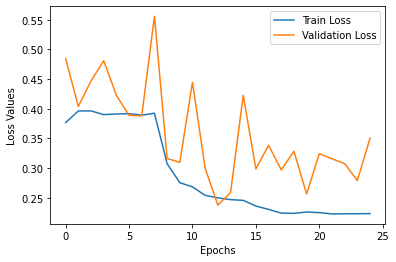


total weights: 1470890 weights zeroed: 882535 in percentage: 0.60000

Test accuracy after IMP:  0.8588938411669368
End Of Iteration


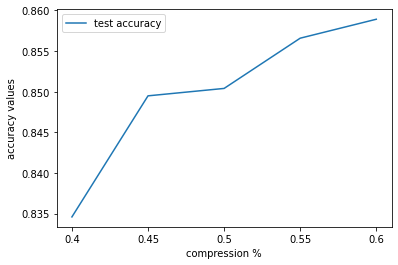

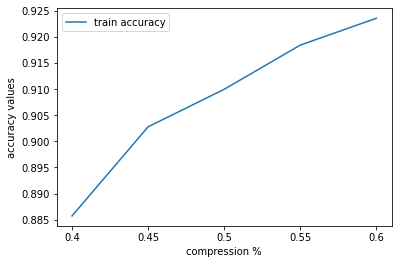

percentage of pruning in this iteration is:  0.65
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.65
Retraining network after applying IMP masks
epoch 0 | train loss : 0.3666015863418579 | validiation loss : 0.379174143075943 | train accuracy: 0.8736 | validiation accuracy: 0.875 |  top 1: 0.8828125 | top 5: 1.0
epoch 1 | train loss : 0.3811928331851959 | validiation loss : 0.36283862590789795 | train accuracy: 0.8730000000000001 | validiation accuracy: 0.8984375 |  top 1: 0.859375 | top 5: 1.0
epoch 2 | train loss : 0.3850938379764557 | validiation loss : 0.4779531955718994 | train accuracy: 0.8668600000000001 | validiation accuracy: 0.859375 |  top 1: 0.84375 | top 5: 0.984375
epoch 3 | train loss : 0.3842650055885315 | validiation loss : 0.3787939250469208 | train accuracy: 0.8724400000000001 | validiation accuracy: 0.84375 |  top 1: 0.875 | top 5: 1.0
epoch 4 | train loss : 0.38564181327819824 | validiation loss : 0.35425424575805664 | train 

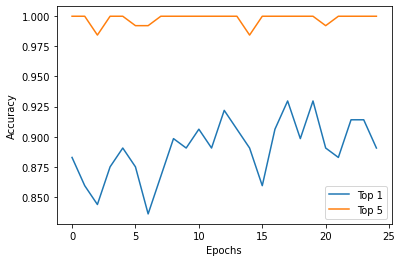

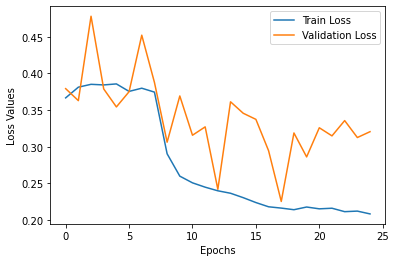


total weights: 1470890 weights zeroed: 956079 in percentage: 0.65000

Test accuracy after IMP:  0.859805510534846
End Of Iteration


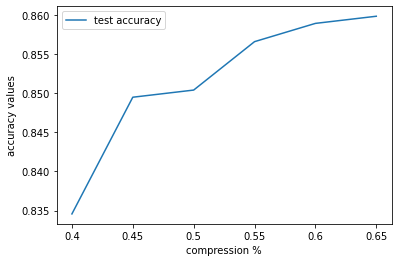

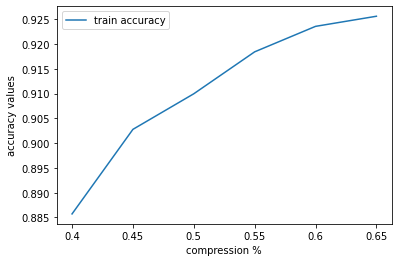

percentage of pruning in this iteration is:  0.7
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.7
Retraining network after applying IMP masks
epoch 0 | train loss : 0.35602647066116333 | validiation loss : 0.3140832483768463 | train accuracy: 0.8771800000000001 | validiation accuracy: 0.9140625 |  top 1: 0.8828125 | top 5: 1.0
epoch 1 | train loss : 0.3736172318458557 | validiation loss : 0.3057446777820587 | train accuracy: 0.8729000000000001 | validiation accuracy: 0.875 |  top 1: 0.890625 | top 5: 1.0
epoch 2 | train loss : 0.3748376667499542 | validiation loss : 0.3567678928375244 | train accuracy: 0.8698600000000001 | validiation accuracy: 0.890625 |  top 1: 0.859375 | top 5: 1.0
epoch 3 | train loss : 0.3643917441368103 | validiation loss : 0.35961639881134033 | train accuracy: 0.87236 | validiation accuracy: 0.90625 |  top 1: 0.90625 | top 5: 0.9921875
epoch 4 | train loss : 0.3712121844291687 | validiation loss : 0.41125303506851196 | tr

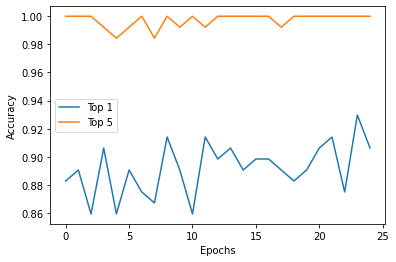

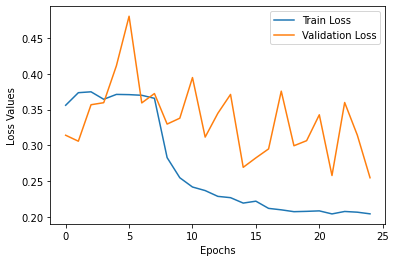


total weights: 1470890 weights zeroed: 1029623 in percentage: 0.70000

Test accuracy after IMP:  0.8618314424635332
End Of Iteration


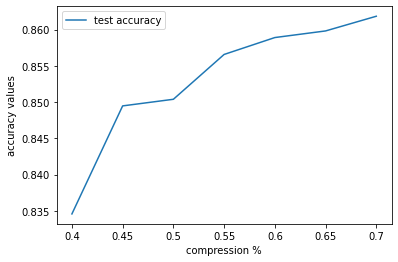

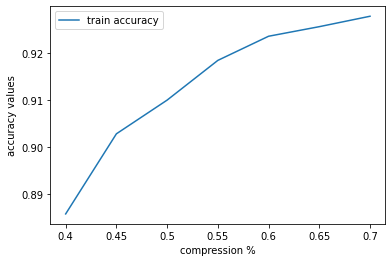

percentage of pruning in this iteration is:  0.75
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.75
Retraining network after applying IMP masks
epoch 0 | train loss : 0.3317013382911682 | validiation loss : 0.3813581168651581 | train accuracy: 0.8820000000000001 | validiation accuracy: 0.8359375 |  top 1: 0.875 | top 5: 0.9921875
epoch 1 | train loss : 0.3584405779838562 | validiation loss : 0.30334270000457764 | train accuracy: 0.8806600000000001 | validiation accuracy: 0.8671875 |  top 1: 0.9140625 | top 5: 1.0
epoch 2 | train loss : 0.35287195444107056 | validiation loss : 0.2968482971191406 | train accuracy: 0.8821000000000001 | validiation accuracy: 0.8828125 |  top 1: 0.921875 | top 5: 1.0
epoch 3 | train loss : 0.35283881425857544 | validiation loss : 0.34125828742980957 | train accuracy: 0.8803000000000001 | validiation accuracy: 0.890625 |  top 1: 0.8828125 | top 5: 0.9921875
epoch 4 | train loss : 0.3541199266910553 | validiation loss 

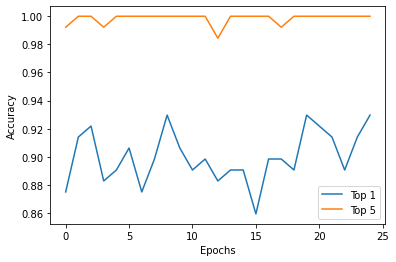

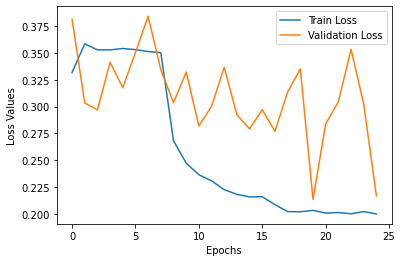


total weights: 1470890 weights zeroed: 1103168 in percentage: 0.75000

Test accuracy after IMP:  0.8634521880064829
End Of Iteration


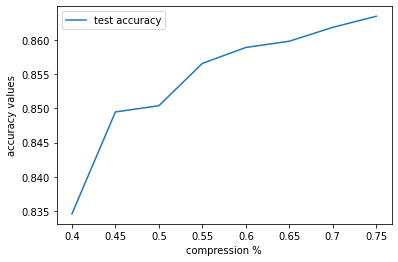

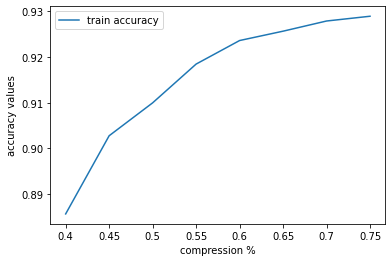

percentage of pruning in this iteration is:  0.8
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.8
Retraining network after applying IMP masks
epoch 0 | train loss : 0.3181145489215851 | validiation loss : 0.3255145251750946 | train accuracy: 0.8901800000000001 | validiation accuracy: 0.890625 |  top 1: 0.8828125 | top 5: 1.0
epoch 1 | train loss : 0.33400481939315796 | validiation loss : 0.2809673547744751 | train accuracy: 0.8934000000000001 | validiation accuracy: 0.8828125 |  top 1: 0.8984375 | top 5: 1.0
epoch 2 | train loss : 0.33860984444618225 | validiation loss : 0.3653075098991394 | train accuracy: 0.8827 | validiation accuracy: 0.890625 |  top 1: 0.8984375 | top 5: 1.0
epoch 3 | train loss : 0.33575448393821716 | validiation loss : 0.384296178817749 | train accuracy: 0.87904 | validiation accuracy: 0.8984375 |  top 1: 0.875 | top 5: 0.9921875
epoch 4 | train loss : 0.33834972977638245 | validiation loss : 0.3453584909439087 | train acc

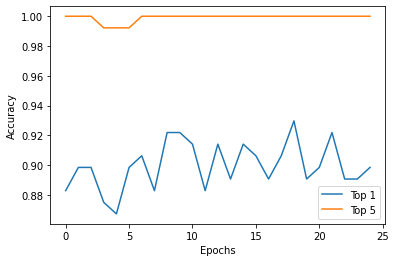

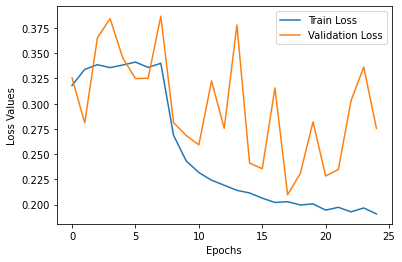


total weights: 1470890 weights zeroed: 1176713 in percentage: 0.80000

Test accuracy after IMP:  0.859805510534846
End Of Iteration


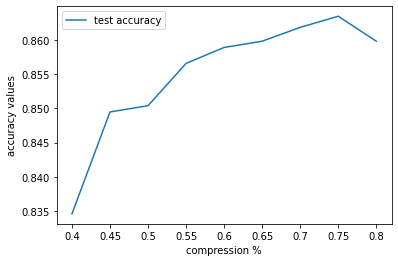

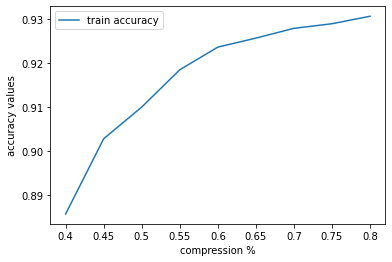

percentage of pruning in this iteration is:  0.85
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.85
Retraining network after applying IMP masks
epoch 0 | train loss : 0.3161628842353821 | validiation loss : 0.33996671438217163 | train accuracy: 0.89048 | validiation accuracy: 0.8671875 |  top 1: 0.8984375 | top 5: 1.0
epoch 1 | train loss : 0.3216007351875305 | validiation loss : 0.33144277334213257 | train accuracy: 0.89148 | validiation accuracy: 0.890625 |  top 1: 0.875 | top 5: 1.0
epoch 2 | train loss : 0.33002176880836487 | validiation loss : 0.35810428857803345 | train accuracy: 0.8868 | validiation accuracy: 0.8984375 |  top 1: 0.8671875 | top 5: 0.9921875
epoch 3 | train loss : 0.3292103707790375 | validiation loss : 0.35198208689689636 | train accuracy: 0.8931800000000001 | validiation accuracy: 0.9140625 |  top 1: 0.890625 | top 5: 1.0
epoch 4 | train loss : 0.3313005566596985 | validiation loss : 0.35924869775772095 | train accuracy:

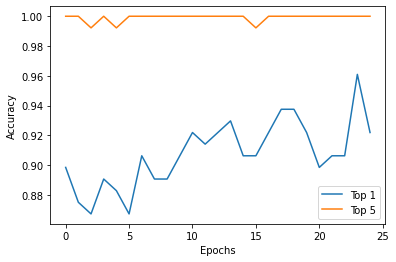

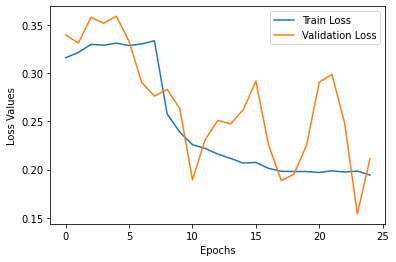


total weights: 1470890 weights zeroed: 1250257 in percentage: 0.85000

Test accuracy after IMP:  0.8617301458670988
End Of Iteration


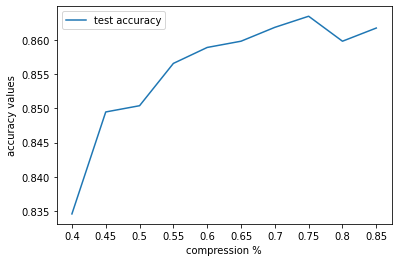

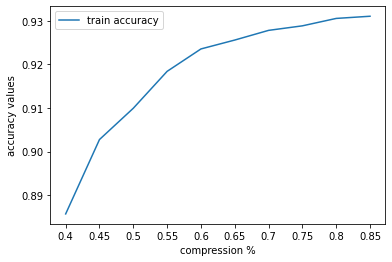

percentage of pruning in this iteration is:  0.9
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.9
Retraining network after applying IMP masks
epoch 0 | train loss : 0.3197897970676422 | validiation loss : 0.35309845209121704 | train accuracy: 0.8866400000000001 | validiation accuracy: 0.859375 |  top 1: 0.890625 | top 5: 1.0
epoch 1 | train loss : 0.3307114541530609 | validiation loss : 0.3827100694179535 | train accuracy: 0.88914 | validiation accuracy: 0.875 |  top 1: 0.875 | top 5: 1.0
epoch 2 | train loss : 0.3298332691192627 | validiation loss : 0.4372159242630005 | train accuracy: 0.8845600000000001 | validiation accuracy: 0.90625 |  top 1: 0.8671875 | top 5: 0.9921875
epoch 3 | train loss : 0.33241307735443115 | validiation loss : 0.3490619659423828 | train accuracy: 0.88882 | validiation accuracy: 0.8125 |  top 1: 0.875 | top 5: 1.0
epoch 4 | train loss : 0.33154237270355225 | validiation loss : 0.30936557054519653 | train accuracy: 0.89

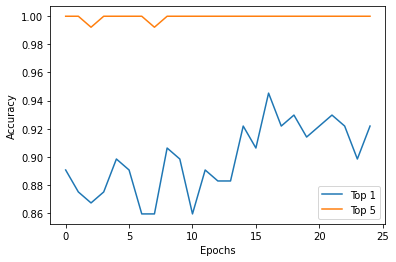

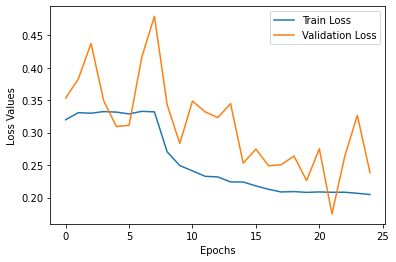


total weights: 1470890 weights zeroed: 1323802 in percentage: 0.90000

Test accuracy after IMP:  0.8580834683954619
End Of Iteration


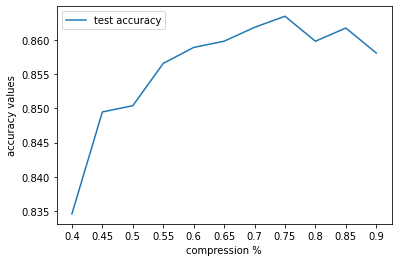

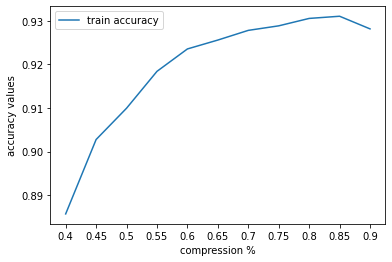

percentage of pruning in this iteration is:  0.91
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.91
Retraining network after applying IMP masks
epoch 0 | train loss : 0.3110198378562927 | validiation loss : 0.40583497285842896 | train accuracy: 0.88102 | validiation accuracy: 0.90625 |  top 1: 0.875 | top 5: 1.0
epoch 1 | train loss : 0.3287679851055145 | validiation loss : 0.38254404067993164 | train accuracy: 0.8869600000000001 | validiation accuracy: 0.8671875 |  top 1: 0.8828125 | top 5: 1.0
epoch 2 | train loss : 0.330322265625 | validiation loss : 0.31640833616256714 | train accuracy: 0.8884000000000001 | validiation accuracy: 0.921875 |  top 1: 0.8984375 | top 5: 0.9921875
epoch 3 | train loss : 0.33756670355796814 | validiation loss : 0.4203696846961975 | train accuracy: 0.88092 | validiation accuracy: 0.8671875 |  top 1: 0.84375 | top 5: 1.0
epoch 4 | train loss : 0.337185800075531 | validiation loss : 0.41473305225372314 | train accura

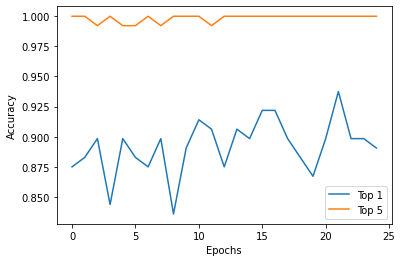

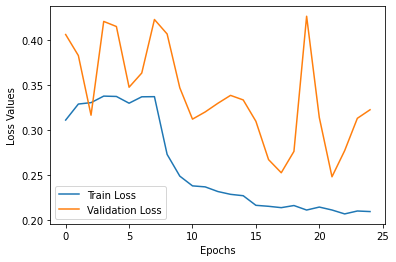


total weights: 1470890 weights zeroed: 1338510 in percentage: 0.91000

Test accuracy after IMP:  0.8599068071312803
End Of Iteration


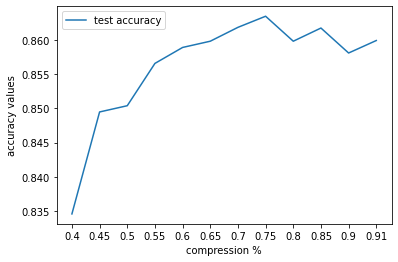

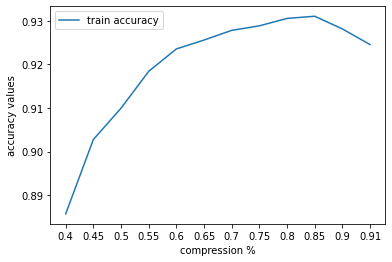

percentage of pruning in this iteration is:  0.92
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.92
Retraining network after applying IMP masks
epoch 0 | train loss : 0.3139304220676422 | validiation loss : 0.4031640887260437 | train accuracy: 0.8909 | validiation accuracy: 0.90625 |  top 1: 0.859375 | top 5: 1.0
epoch 1 | train loss : 0.32819053530693054 | validiation loss : 0.3366931974887848 | train accuracy: 0.89314 | validiation accuracy: 0.8984375 |  top 1: 0.890625 | top 5: 1.0
epoch 2 | train loss : 0.33487051725387573 | validiation loss : 0.31297117471694946 | train accuracy: 0.8874000000000001 | validiation accuracy: 0.90625 |  top 1: 0.875 | top 5: 1.0
epoch 3 | train loss : 0.3358954191207886 | validiation loss : 0.3390454053878784 | train accuracy: 0.88724 | validiation accuracy: 0.875 |  top 1: 0.90625 | top 5: 0.9921875
epoch 4 | train loss : 0.328623503446579 | validiation loss : 0.43530207872390747 | train accuracy: 0.8841800000

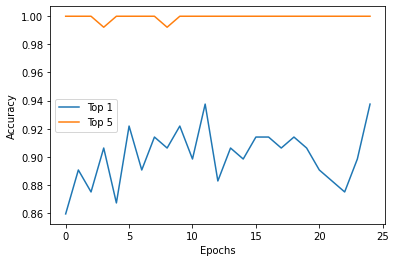

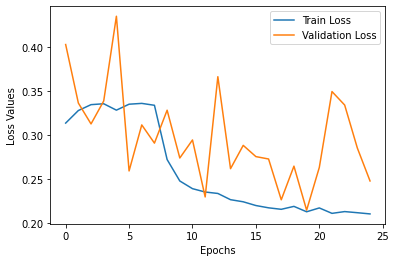


total weights: 1470890 weights zeroed: 1353219 in percentage: 0.92000

Test accuracy after IMP:  0.8605145867098865
End Of Iteration


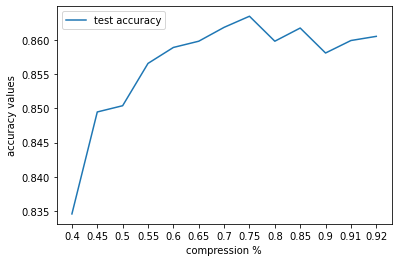

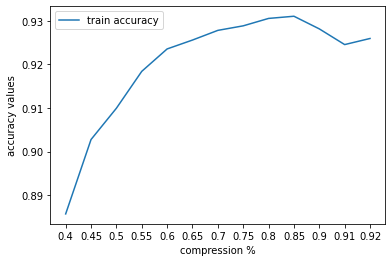

percentage of pruning in this iteration is:  0.93
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.93
Retraining network after applying IMP masks
epoch 0 | train loss : 0.32114580273628235 | validiation loss : 0.30593693256378174 | train accuracy: 0.8859400000000001 | validiation accuracy: 0.859375 |  top 1: 0.90625 | top 5: 0.9921875
epoch 1 | train loss : 0.33532384037971497 | validiation loss : 0.40814411640167236 | train accuracy: 0.8831200000000001 | validiation accuracy: 0.890625 |  top 1: 0.8515625 | top 5: 1.0
epoch 2 | train loss : 0.3348810076713562 | validiation loss : 0.36649248003959656 | train accuracy: 0.8851000000000001 | validiation accuracy: 0.8828125 |  top 1: 0.8984375 | top 5: 1.0
epoch 3 | train loss : 0.33781883120536804 | validiation loss : 0.3433539867401123 | train accuracy: 0.8842200000000001 | validiation accuracy: 0.859375 |  top 1: 0.8828125 | top 5: 1.0
epoch 4 | train loss : 0.3394894003868103 | validiation loss : 0

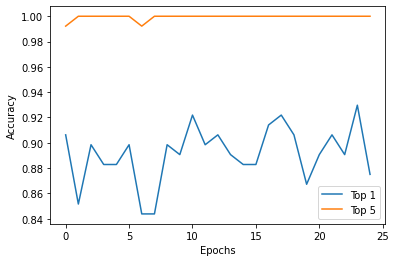

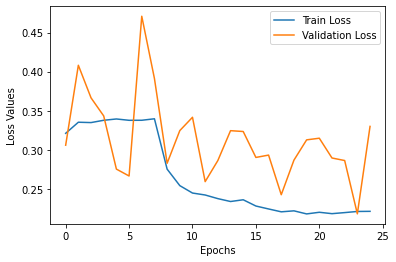


total weights: 1470890 weights zeroed: 1367928 in percentage: 0.93000

Test accuracy after IMP:  0.8595016207455429
End Of Iteration


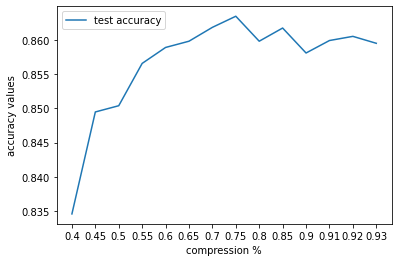

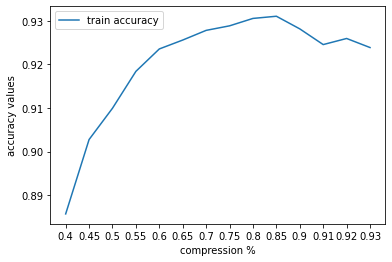

percentage of pruning in this iteration is:  0.94
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.94
Retraining network after applying IMP masks
epoch 0 | train loss : 0.32640376687049866 | validiation loss : 0.42176488041877747 | train accuracy: 0.8844000000000001 | validiation accuracy: 0.8515625 |  top 1: 0.859375 | top 5: 1.0
epoch 1 | train loss : 0.3368680775165558 | validiation loss : 0.3466882109642029 | train accuracy: 0.88582 | validiation accuracy: 0.8359375 |  top 1: 0.8828125 | top 5: 1.0
epoch 2 | train loss : 0.34188663959503174 | validiation loss : 0.2819675803184509 | train accuracy: 0.88768 | validiation accuracy: 0.8828125 |  top 1: 0.921875 | top 5: 1.0
epoch 3 | train loss : 0.3390946388244629 | validiation loss : 0.33435383439064026 | train accuracy: 0.8845200000000001 | validiation accuracy: 0.8828125 |  top 1: 0.8984375 | top 5: 1.0
epoch 4 | train loss : 0.3415561020374298 | validiation loss : 0.2999056875705719 | train a

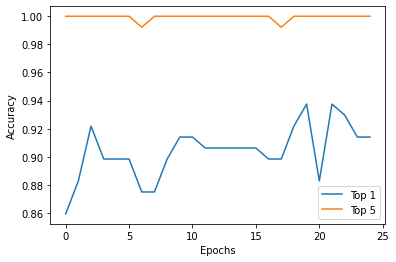

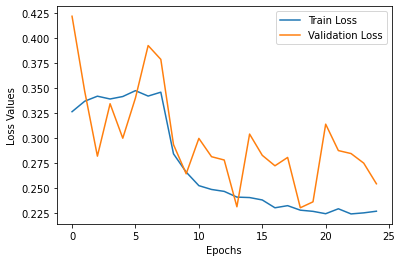


total weights: 1470890 weights zeroed: 1382637 in percentage: 0.94000

Test accuracy after IMP:  0.8559562398703403
End Of Iteration


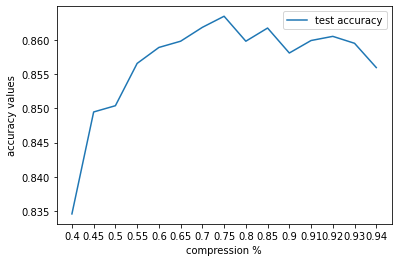

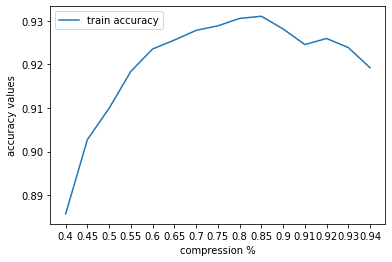

percentage of pruning in this iteration is:  0.95
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.95
Retraining network after applying IMP masks
epoch 0 | train loss : 0.3392232656478882 | validiation loss : 0.339232861995697 | train accuracy: 0.8814400000000001 | validiation accuracy: 0.90625 |  top 1: 0.8984375 | top 5: 0.9921875
epoch 1 | train loss : 0.3544737696647644 | validiation loss : 0.41958916187286377 | train accuracy: 0.8813000000000001 | validiation accuracy: 0.8828125 |  top 1: 0.8671875 | top 5: 1.0
epoch 2 | train loss : 0.35648784041404724 | validiation loss : 0.3455628454685211 | train accuracy: 0.8796400000000001 | validiation accuracy: 0.890625 |  top 1: 0.90625 | top 5: 1.0
epoch 3 | train loss : 0.35609549283981323 | validiation loss : 0.3819241225719452 | train accuracy: 0.8804400000000001 | validiation accuracy: 0.8671875 |  top 1: 0.859375 | top 5: 0.984375
epoch 4 | train loss : 0.35539838671684265 | validiation loss : 

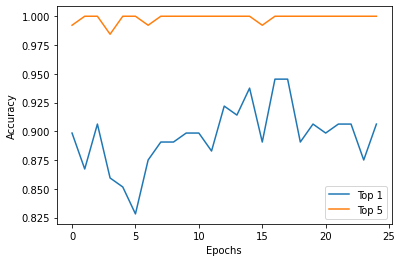

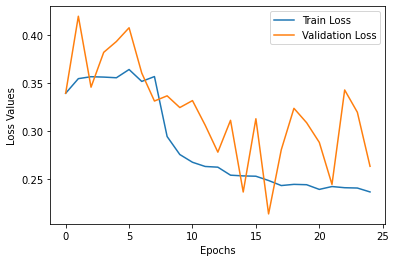


total weights: 1470890 weights zeroed: 1397346 in percentage: 0.95000

Test accuracy after IMP:  0.8518030794165316
End Of Iteration


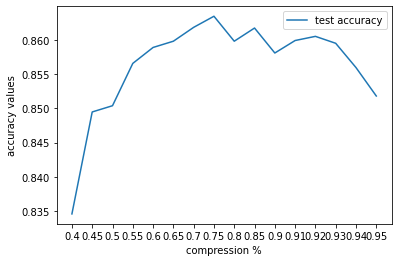

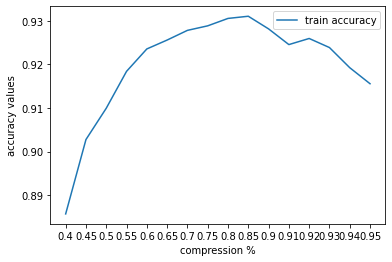

percentage of pruning in this iteration is:  0.96
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.96
Retraining network after applying IMP masks
epoch 0 | train loss : 0.3625040352344513 | validiation loss : 0.36426496505737305 | train accuracy: 0.8767600000000001 | validiation accuracy: 0.90625 |  top 1: 0.890625 | top 5: 1.0
epoch 1 | train loss : 0.3749975562095642 | validiation loss : 0.3980540633201599 | train accuracy: 0.8762800000000001 | validiation accuracy: 0.8984375 |  top 1: 0.8828125 | top 5: 1.0
epoch 2 | train loss : 0.3718562126159668 | validiation loss : 0.34375637769699097 | train accuracy: 0.87194 | validiation accuracy: 0.859375 |  top 1: 0.890625 | top 5: 1.0
epoch 3 | train loss : 0.3762527406215668 | validiation loss : 0.38610073924064636 | train accuracy: 0.8733400000000001 | validiation accuracy: 0.8125 |  top 1: 0.875 | top 5: 1.0
epoch 4 | train loss : 0.37222445011138916 | validiation loss : 0.45557111501693726 | train

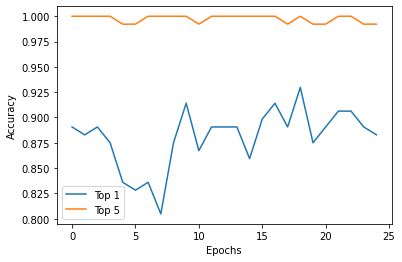

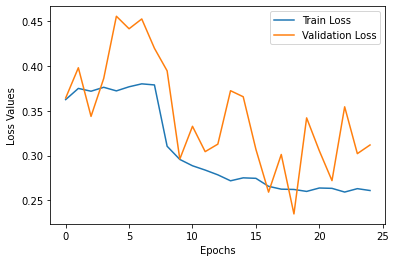


total weights: 1470890 weights zeroed: 1412055 in percentage: 0.96000

Test accuracy after IMP:  0.8501823338735818
End Of Iteration


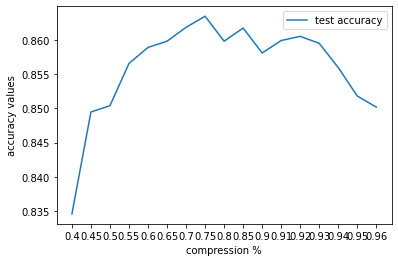

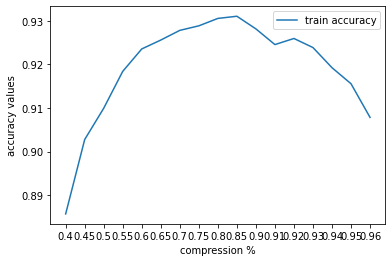

percentage of pruning in this iteration is:  0.97
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.97
Retraining network after applying IMP masks
epoch 0 | train loss : 0.405385822057724 | validiation loss : 0.39792054891586304 | train accuracy: 0.8641800000000001 | validiation accuracy: 0.84375 |  top 1: 0.8671875 | top 5: 1.0
epoch 1 | train loss : 0.41519609093666077 | validiation loss : 0.49573105573654175 | train accuracy: 0.8616800000000001 | validiation accuracy: 0.8359375 |  top 1: 0.8203125 | top 5: 0.9921875
epoch 2 | train loss : 0.4167690873146057 | validiation loss : 0.4758702218532562 | train accuracy: 0.8641800000000001 | validiation accuracy: 0.859375 |  top 1: 0.875 | top 5: 0.984375
epoch 3 | train loss : 0.4130900800228119 | validiation loss : 0.4202708601951599 | train accuracy: 0.8626 | validiation accuracy: 0.84375 |  top 1: 0.8515625 | top 5: 0.9921875
epoch 4 | train loss : 0.40871623158454895 | validiation loss : 0.4959674

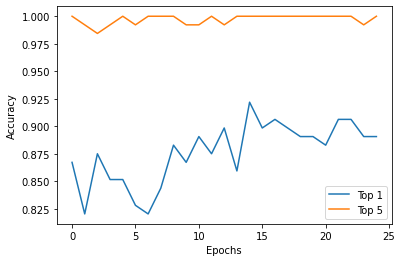

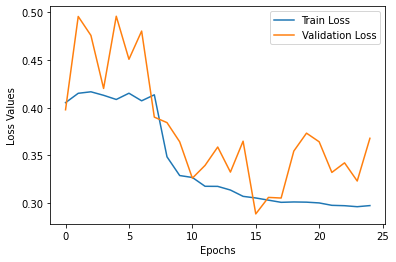


total weights: 1470890 weights zeroed: 1426764 in percentage: 0.97000

Test accuracy after IMP:  0.8423824959481361
End Of Iteration


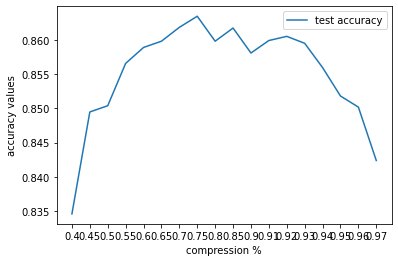

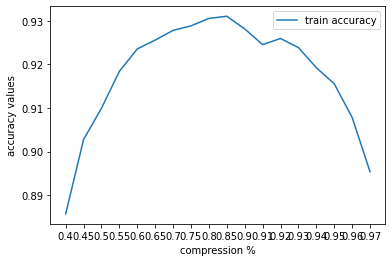

percentage of pruning in this iteration is:  0.98
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.98
Retraining network after applying IMP masks
epoch 0 | train loss : 0.49016687273979187 | validiation loss : 0.550094485282898 | train accuracy: 0.83172 | validiation accuracy: 0.859375 |  top 1: 0.8203125 | top 5: 0.9921875
epoch 1 | train loss : 0.4860534965991974 | validiation loss : 0.48296767473220825 | train accuracy: 0.83442 | validiation accuracy: 0.828125 |  top 1: 0.859375 | top 5: 0.984375
epoch 2 | train loss : 0.4818883538246155 | validiation loss : 0.3972722589969635 | train accuracy: 0.8349200000000001 | validiation accuracy: 0.84375 |  top 1: 0.8671875 | top 5: 1.0
epoch 3 | train loss : 0.4850105941295624 | validiation loss : 0.4880232810974121 | train accuracy: 0.8374 | validiation accuracy: 0.828125 |  top 1: 0.8125 | top 5: 1.0
epoch 4 | train loss : 0.47346195578575134 | validiation loss : 0.5050817728042603 | train accuracy: 0

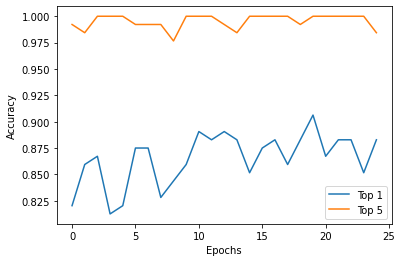

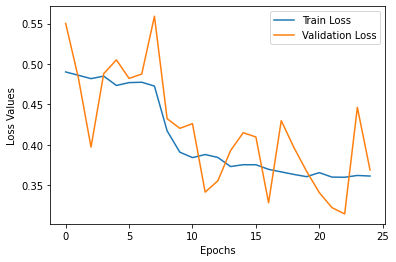


total weights: 1470890 weights zeroed: 1441473 in percentage: 0.98000

Test accuracy after IMP:  0.8285048622366288
End Of Iteration


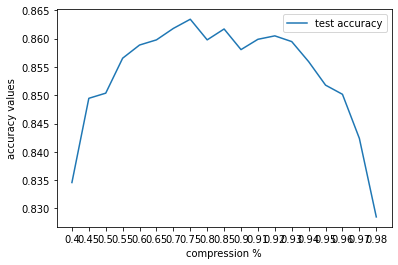

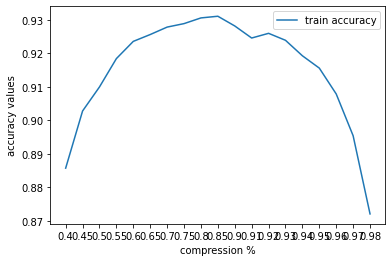

percentage of pruning in this iteration is:  0.99
Calculating Iterative Magnitude Prunning (IMP) masks
imp target percentage to prune:  0.99
Retraining network after applying IMP masks
epoch 0 | train loss : 0.725940465927124 | validiation loss : 0.6475547552108765 | train accuracy: 0.7657600000000001 | validiation accuracy: 0.796875 |  top 1: 0.7734375 | top 5: 0.984375
epoch 1 | train loss : 0.6840860843658447 | validiation loss : 0.7264866828918457 | train accuracy: 0.7635400000000001 | validiation accuracy: 0.8125 |  top 1: 0.7734375 | top 5: 1.0
epoch 2 | train loss : 0.6759055852890015 | validiation loss : 0.7638262510299683 | train accuracy: 0.7653000000000001 | validiation accuracy: 0.765625 |  top 1: 0.8046875 | top 5: 0.984375
epoch 3 | train loss : 0.6640604734420776 | validiation loss : 0.602155864238739 | train accuracy: 0.7666200000000001 | validiation accuracy: 0.796875 |  top 1: 0.7890625 | top 5: 0.9921875
epoch 4 | train loss : 0.6649430394172668 | validiation loss : 

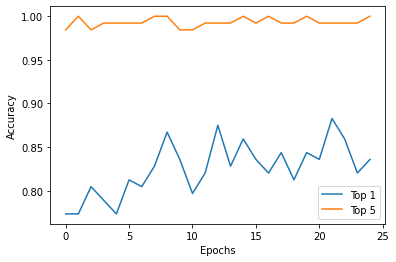

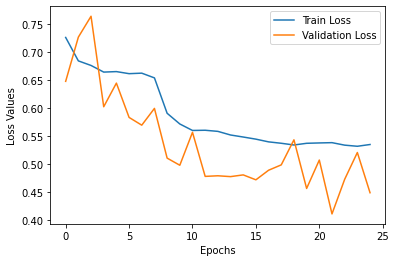


total weights: 1470890 weights zeroed: 1456182 in percentage: 0.99000

Test accuracy after IMP:  0.7763371150729335
End Of Iteration


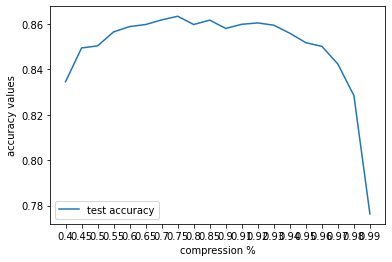

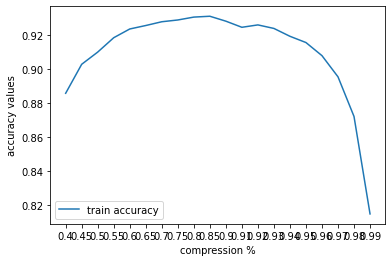

In [ ]:
import time

net_name = "CIFAR10_conv_nn_IMP_only"
net = Net_With_BN_Dropout(3).to(device)

loss_on_pruning = []

test_accuracy = []
train_accuracy = []
training_loss = []
prune_percent_list = []

# measure start time
st = time.time()

print("start inital training")
train_acc_list, val_acc_list, test_acc_list, epoch_stopped, best_model = run_custom_train(net, []) 

print("validation accuracy after inital training: ", test_acc_list[-1])

while imp_prune_percentage < 1:
    print("percentage of pruning in this iteration is: ", imp_prune_percentage)
    prune_percent_list.append(imp_prune_percentage)
                             
    print("Calculating Iterative Magnitude Prunning (IMP) masks")
    imp_mask_list = imp(net, imp_prune_percentage) 
    # increase prune percentage for next round
    if imp_prune_percentage < 0.9:
        imp_prune_percentage += imp_percentage_increase
    else:
        imp_prune_percentage += 0.01
    imp_prune_percentage = round(imp_prune_percentage, 2)    
    print("Retraining network after applying IMP masks")    
    train_acc_list, val_acc_list, test_acc_list, epoch_stopped, best_model = run_custom_train(net, imp_mask_list) 
    net = best_model    
    test_acc = calculate_acc(loader_test, net)
    test_accuracy.append(test_acc)
    train_acc = calculate_acc(loader_train, net)
    train_accuracy.append(train_acc)
    print("Test accuracy after IMP: ", test_acc)
    
    print("End Of Iteration")
    # added here in order to display graphs even if program crashes due to internet connection
    plot_graph("test accuracy after IMP", 'compression %', 'accuracy values', [test_accuracy], ['test accuracy'], 0, prune_percent_list)
    plot_graph("train accuracy after IMP", 'compression %', 'accuracy values', [train_accuracy], ['train accuracy'], 0, prune_percent_list)
print(test_accuracy)
# measure the end time

et = time.time()
print("start time: ", st, "end time: ", et, "total time in minutes: ", (et-st)/60)
runtime.unassign()


## ALDS One-Shot testing

Performing initial model training
Training Progress: Epoch [ 1/25] | Step [  0/391] | Loss: 2.299640 | Top1: 13.28% | Top5: 52.34% | Elapsed Time: 7.45s
Training Progress: Epoch [ 1/25] | Step [ 39/391] | Loss: 2.279508 | Top1: 15.62% | Top5: 64.06% | Elapsed Time: 2.10s
Training Progress: Epoch [ 1/25] | Step [ 78/391] | Loss: 2.126554 | Top1: 21.09% | Top5: 75.78% | Elapsed Time: 1.98s
Training Progress: Epoch [ 1/25] | Step [117/391] | Loss: 1.868814 | Top1: 32.03% | Top5: 84.38% | Elapsed Time: 1.97s
Training Progress: Epoch [ 1/25] | Step [156/391] | Loss: 1.731011 | Top1: 39.06% | Top5: 87.50% | Elapsed Time: 2.07s
Training Progress: Epoch [ 1/25] | Step [195/391] | Loss: 1.797589 | Top1: 32.81% | Top5: 81.25% | Elapsed Time: 2.03s
Training Progress: Epoch [ 1/25] | Step [234/391] | Loss: 1.607971 | Top1: 40.62% | Top5: 88.28% | Elapsed Time: 2.94s
Training Progress: Epoch [ 1/25] | Step [273/391] | Loss: 1.554021 | Top1: 45.31% | Top5: 93.75% | Elapsed Time: 3.13s
Training Progr

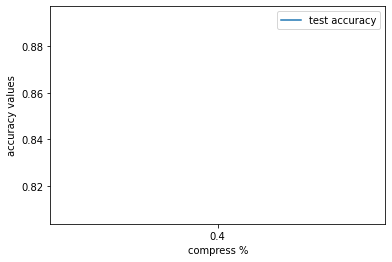

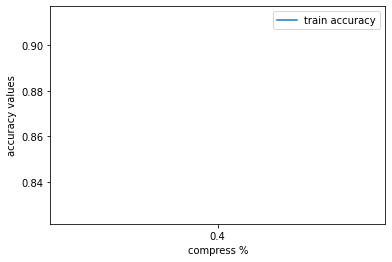

Performing initial model training
Training Progress: Epoch [ 1/25] | Step [  0/391] | Loss: 2.277467 | Top1: 12.50% | Top5: 58.59% | Elapsed Time: 0.09s
Training Progress: Epoch [ 1/25] | Step [ 39/391] | Loss: 2.280701 | Top1: 12.50% | Top5: 50.78% | Elapsed Time: 1.91s
Training Progress: Epoch [ 1/25] | Step [ 78/391] | Loss: 2.093939 | Top1: 20.31% | Top5: 82.03% | Elapsed Time: 1.92s
Training Progress: Epoch [ 1/25] | Step [117/391] | Loss: 1.834627 | Top1: 35.16% | Top5: 83.59% | Elapsed Time: 1.94s
Training Progress: Epoch [ 1/25] | Step [156/391] | Loss: 1.692384 | Top1: 29.69% | Top5: 89.06% | Elapsed Time: 1.91s
Training Progress: Epoch [ 1/25] | Step [195/391] | Loss: 1.626200 | Top1: 38.28% | Top5: 92.19% | Elapsed Time: 1.89s
Training Progress: Epoch [ 1/25] | Step [234/391] | Loss: 1.486117 | Top1: 39.84% | Top5: 92.97% | Elapsed Time: 2.80s
Training Progress: Epoch [ 1/25] | Step [273/391] | Loss: 1.594979 | Top1: 39.84% | Top5: 91.41% | Elapsed Time: 2.98s
Training Progr

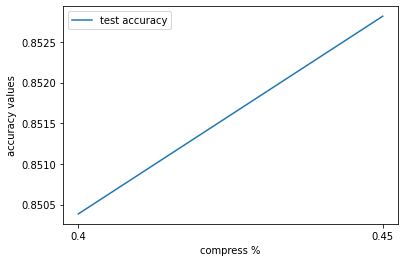

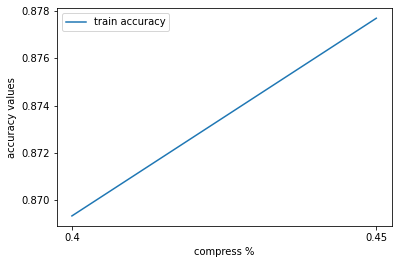

Performing initial model training
Training Progress: Epoch [ 1/25] | Step [  0/391] | Loss: 2.307913 | Top1: 10.94% | Top5: 49.22% | Elapsed Time: 0.08s
Training Progress: Epoch [ 1/25] | Step [ 39/391] | Loss: 2.265062 | Top1: 15.62% | Top5: 60.94% | Elapsed Time: 1.93s
Training Progress: Epoch [ 1/25] | Step [ 78/391] | Loss: 2.081822 | Top1: 21.88% | Top5: 82.03% | Elapsed Time: 1.89s
Training Progress: Epoch [ 1/25] | Step [117/391] | Loss: 1.796428 | Top1: 32.03% | Top5: 82.03% | Elapsed Time: 1.89s
Training Progress: Epoch [ 1/25] | Step [156/391] | Loss: 1.781986 | Top1: 34.38% | Top5: 82.03% | Elapsed Time: 2.46s
Training Progress: Epoch [ 1/25] | Step [195/391] | Loss: 1.577278 | Top1: 41.41% | Top5: 92.19% | Elapsed Time: 3.23s
Training Progress: Epoch [ 1/25] | Step [234/391] | Loss: 1.643668 | Top1: 35.16% | Top5: 87.50% | Elapsed Time: 2.11s
Training Progress: Epoch [ 1/25] | Step [273/391] | Loss: 1.620046 | Top1: 42.97% | Top5: 87.50% | Elapsed Time: 1.89s
Training Progr

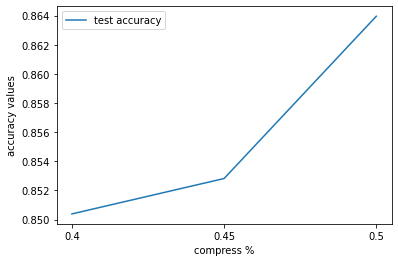

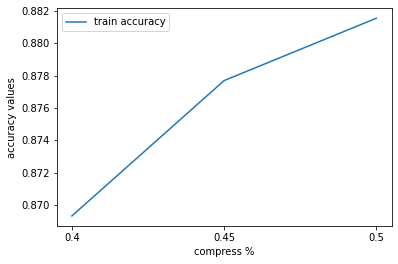

Performing initial model training
Training Progress: Epoch [ 1/25] | Step [  0/391] | Loss: 2.314655 | Top1: 5.47% | Top5: 48.44% | Elapsed Time: 0.08s
Training Progress: Epoch [ 1/25] | Step [ 39/391] | Loss: 2.299001 | Top1: 10.94% | Top5: 52.34% | Elapsed Time: 2.77s
Training Progress: Epoch [ 1/25] | Step [ 78/391] | Loss: 2.165350 | Top1: 16.41% | Top5: 75.78% | Elapsed Time: 2.97s
Training Progress: Epoch [ 1/25] | Step [117/391] | Loss: 1.864247 | Top1: 28.12% | Top5: 80.47% | Elapsed Time: 1.88s
Training Progress: Epoch [ 1/25] | Step [156/391] | Loss: 1.661881 | Top1: 36.72% | Top5: 89.84% | Elapsed Time: 1.88s
Training Progress: Epoch [ 1/25] | Step [195/391] | Loss: 1.574840 | Top1: 40.62% | Top5: 91.41% | Elapsed Time: 1.90s
Training Progress: Epoch [ 1/25] | Step [234/391] | Loss: 1.467652 | Top1: 37.50% | Top5: 90.62% | Elapsed Time: 1.91s
Training Progress: Epoch [ 1/25] | Step [273/391] | Loss: 1.451150 | Top1: 46.88% | Top5: 91.41% | Elapsed Time: 1.91s
Training Progre

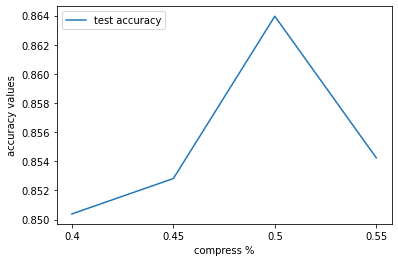

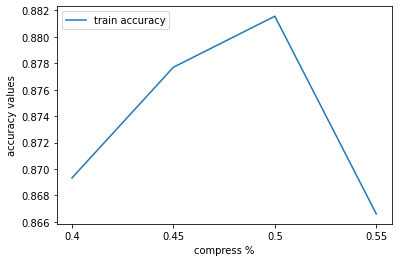

Performing initial model training
Training Progress: Epoch [ 1/25] | Step [  0/391] | Loss: 2.344755 | Top1: 3.91% | Top5: 43.75% | Elapsed Time: 0.11s
Training Progress: Epoch [ 1/25] | Step [ 39/391] | Loss: 2.290819 | Top1: 7.81% | Top5: 59.38% | Elapsed Time: 2.86s
Training Progress: Epoch [ 1/25] | Step [ 78/391] | Loss: 2.111105 | Top1: 17.97% | Top5: 77.34% | Elapsed Time: 2.73s
Training Progress: Epoch [ 1/25] | Step [117/391] | Loss: 1.816387 | Top1: 33.59% | Top5: 84.38% | Elapsed Time: 1.87s
Training Progress: Epoch [ 1/25] | Step [156/391] | Loss: 1.637959 | Top1: 39.06% | Top5: 89.84% | Elapsed Time: 1.85s
Training Progress: Epoch [ 1/25] | Step [195/391] | Loss: 1.614812 | Top1: 34.38% | Top5: 88.28% | Elapsed Time: 1.83s
Training Progress: Epoch [ 1/25] | Step [234/391] | Loss: 1.677873 | Top1: 33.59% | Top5: 88.28% | Elapsed Time: 1.84s
Training Progress: Epoch [ 1/25] | Step [273/391] | Loss: 1.646688 | Top1: 34.38% | Top5: 85.16% | Elapsed Time: 1.98s
Training Progres

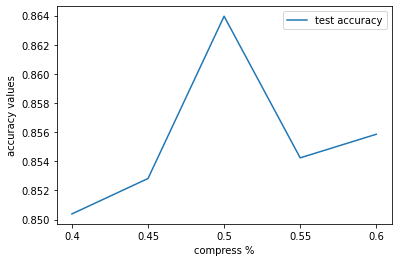

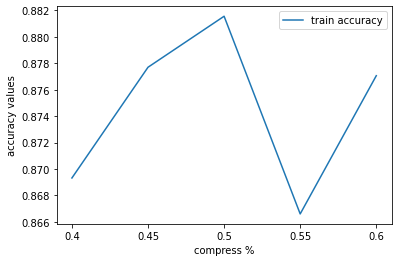

Performing initial model training
Training Progress: Epoch [ 1/25] | Step [  0/391] | Loss: 2.300791 | Top1: 9.38% | Top5: 59.38% | Elapsed Time: 0.14s
Training Progress: Epoch [ 1/25] | Step [ 39/391] | Loss: 2.272250 | Top1: 15.62% | Top5: 58.59% | Elapsed Time: 2.97s
Training Progress: Epoch [ 1/25] | Step [ 78/391] | Loss: 2.045824 | Top1: 18.75% | Top5: 80.47% | Elapsed Time: 1.84s
Training Progress: Epoch [ 1/25] | Step [117/391] | Loss: 1.783420 | Top1: 35.16% | Top5: 89.84% | Elapsed Time: 1.85s
Training Progress: Epoch [ 1/25] | Step [156/391] | Loss: 1.629429 | Top1: 36.72% | Top5: 88.28% | Elapsed Time: 1.87s
Training Progress: Epoch [ 1/25] | Step [195/391] | Loss: 1.597185 | Top1: 45.31% | Top5: 89.06% | Elapsed Time: 1.85s
Training Progress: Epoch [ 1/25] | Step [234/391] | Loss: 1.457612 | Top1: 46.88% | Top5: 94.53% | Elapsed Time: 2.01s
Training Progress: Epoch [ 1/25] | Step [273/391] | Loss: 1.543502 | Top1: 46.09% | Top5: 88.28% | Elapsed Time: 2.88s
Training Progre

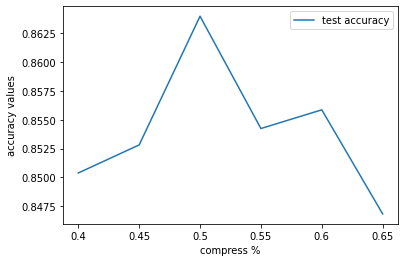

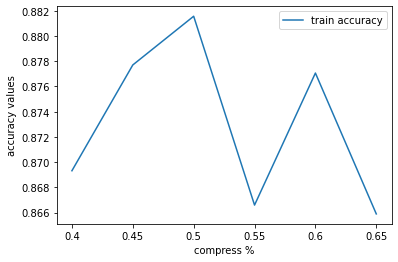

Performing initial model training
Training Progress: Epoch [ 1/25] | Step [  0/391] | Loss: 2.326596 | Top1: 7.81% | Top5: 42.97% | Elapsed Time: 0.08s
Training Progress: Epoch [ 1/25] | Step [ 39/391] | Loss: 2.288294 | Top1: 11.72% | Top5: 62.50% | Elapsed Time: 1.84s
Training Progress: Epoch [ 1/25] | Step [ 78/391] | Loss: 2.136327 | Top1: 14.84% | Top5: 75.78% | Elapsed Time: 1.85s
Training Progress: Epoch [ 1/25] | Step [117/391] | Loss: 1.871737 | Top1: 31.25% | Top5: 83.59% | Elapsed Time: 1.84s
Training Progress: Epoch [ 1/25] | Step [156/391] | Loss: 1.814068 | Top1: 24.22% | Top5: 88.28% | Elapsed Time: 1.83s
Training Progress: Epoch [ 1/25] | Step [195/391] | Loss: 1.770973 | Top1: 34.38% | Top5: 89.06% | Elapsed Time: 2.22s
Training Progress: Epoch [ 1/25] | Step [234/391] | Loss: 1.606509 | Top1: 43.75% | Top5: 91.41% | Elapsed Time: 2.95s
Training Progress: Epoch [ 1/25] | Step [273/391] | Loss: 1.594391 | Top1: 39.84% | Top5: 90.62% | Elapsed Time: 2.30s
Training Progre

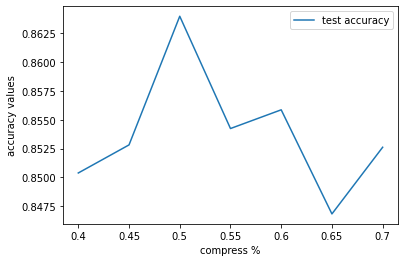

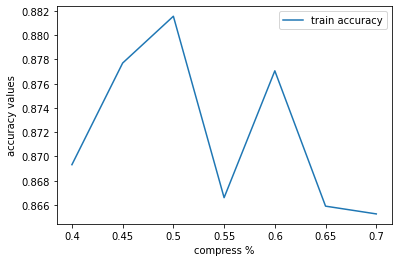

Performing initial model training
Training Progress: Epoch [ 1/25] | Step [  0/391] | Loss: 2.312819 | Top1: 9.38% | Top5: 50.00% | Elapsed Time: 0.08s
Training Progress: Epoch [ 1/25] | Step [ 39/391] | Loss: 2.262953 | Top1: 14.06% | Top5: 69.53% | Elapsed Time: 2.11s
Training Progress: Epoch [ 1/25] | Step [ 78/391] | Loss: 2.062590 | Top1: 29.69% | Top5: 78.12% | Elapsed Time: 2.96s
Training Progress: Epoch [ 1/25] | Step [117/391] | Loss: 1.774004 | Top1: 32.03% | Top5: 82.81% | Elapsed Time: 2.54s
Training Progress: Epoch [ 1/25] | Step [156/391] | Loss: 1.667491 | Top1: 39.06% | Top5: 89.06% | Elapsed Time: 1.83s
Training Progress: Epoch [ 1/25] | Step [195/391] | Loss: 1.569183 | Top1: 50.00% | Top5: 88.28% | Elapsed Time: 1.86s
Training Progress: Epoch [ 1/25] | Step [234/391] | Loss: 1.790353 | Top1: 37.50% | Top5: 89.06% | Elapsed Time: 1.87s
Training Progress: Epoch [ 1/25] | Step [273/391] | Loss: 1.415091 | Top1: 46.09% | Top5: 92.19% | Elapsed Time: 1.86s
Training Progre

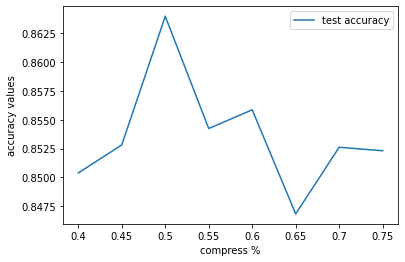

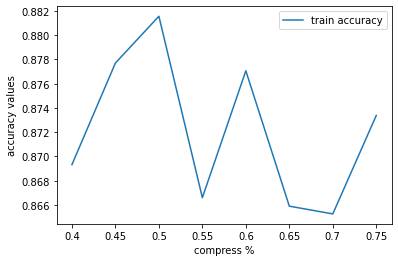

Performing initial model training
Training Progress: Epoch [ 1/25] | Step [  0/391] | Loss: 2.320286 | Top1: 6.25% | Top5: 49.22% | Elapsed Time: 0.30s
Training Progress: Epoch [ 1/25] | Step [ 39/391] | Loss: 2.286605 | Top1: 15.62% | Top5: 60.94% | Elapsed Time: 3.01s
Training Progress: Epoch [ 1/25] | Step [ 78/391] | Loss: 2.061058 | Top1: 25.78% | Top5: 73.44% | Elapsed Time: 1.91s
Training Progress: Epoch [ 1/25] | Step [117/391] | Loss: 1.893240 | Top1: 35.16% | Top5: 81.25% | Elapsed Time: 1.88s
Training Progress: Epoch [ 1/25] | Step [156/391] | Loss: 1.861830 | Top1: 31.25% | Top5: 83.59% | Elapsed Time: 1.89s
Training Progress: Epoch [ 1/25] | Step [195/391] | Loss: 1.693251 | Top1: 41.41% | Top5: 88.28% | Elapsed Time: 1.88s
Training Progress: Epoch [ 1/25] | Step [234/391] | Loss: 1.690099 | Top1: 38.28% | Top5: 88.28% | Elapsed Time: 1.93s
Training Progress: Epoch [ 1/25] | Step [273/391] | Loss: 1.532093 | Top1: 42.19% | Top5: 91.41% | Elapsed Time: 2.69s
Training Progre

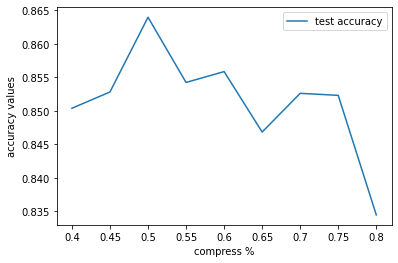

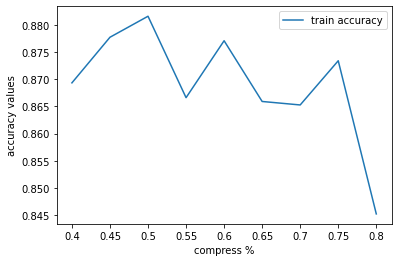

Performing initial model training
Training Progress: Epoch [ 1/25] | Step [  0/391] | Loss: 2.308777 | Top1: 11.72% | Top5: 54.69% | Elapsed Time: 0.11s
Training Progress: Epoch [ 1/25] | Step [ 39/391] | Loss: 2.286062 | Top1: 7.81% | Top5: 54.69% | Elapsed Time: 3.16s
Training Progress: Epoch [ 1/25] | Step [ 78/391] | Loss: 2.084164 | Top1: 21.09% | Top5: 76.56% | Elapsed Time: 2.11s
Training Progress: Epoch [ 1/25] | Step [117/391] | Loss: 1.778734 | Top1: 32.03% | Top5: 85.16% | Elapsed Time: 1.86s
Training Progress: Epoch [ 1/25] | Step [156/391] | Loss: 1.655032 | Top1: 32.03% | Top5: 88.28% | Elapsed Time: 1.94s
Training Progress: Epoch [ 1/25] | Step [195/391] | Loss: 1.609080 | Top1: 42.97% | Top5: 90.62% | Elapsed Time: 1.84s
Training Progress: Epoch [ 1/25] | Step [234/391] | Loss: 1.488782 | Top1: 39.06% | Top5: 89.06% | Elapsed Time: 1.90s
Training Progress: Epoch [ 1/25] | Step [273/391] | Loss: 1.527677 | Top1: 41.41% | Top5: 93.75% | Elapsed Time: 2.37s
Training Progre

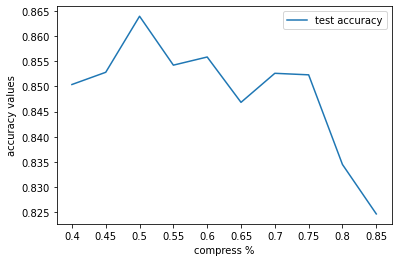

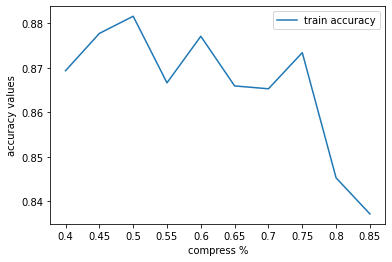

Performing initial model training
Training Progress: Epoch [ 1/25] | Step [  0/391] | Loss: 2.326422 | Top1: 10.16% | Top5: 48.44% | Elapsed Time: 0.13s
Training Progress: Epoch [ 1/25] | Step [ 39/391] | Loss: 2.291269 | Top1: 15.62% | Top5: 54.69% | Elapsed Time: 2.78s
Training Progress: Epoch [ 1/25] | Step [ 78/391] | Loss: 2.121108 | Top1: 22.66% | Top5: 75.00% | Elapsed Time: 2.00s
Training Progress: Epoch [ 1/25] | Step [117/391] | Loss: 1.846246 | Top1: 32.03% | Top5: 83.59% | Elapsed Time: 2.08s
Training Progress: Epoch [ 1/25] | Step [156/391] | Loss: 1.745736 | Top1: 35.16% | Top5: 84.38% | Elapsed Time: 1.97s
Training Progress: Epoch [ 1/25] | Step [195/391] | Loss: 1.731714 | Top1: 31.25% | Top5: 92.19% | Elapsed Time: 1.94s
Training Progress: Epoch [ 1/25] | Step [234/391] | Loss: 1.635290 | Top1: 35.94% | Top5: 89.84% | Elapsed Time: 2.47s
Training Progress: Epoch [ 1/25] | Step [273/391] | Loss: 1.572650 | Top1: 45.31% | Top5: 89.06% | Elapsed Time: 3.19s
Training Progr

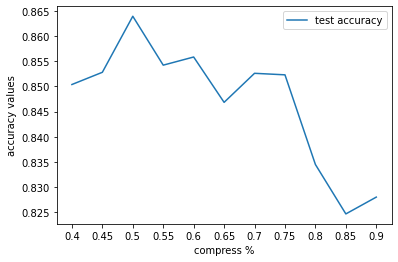

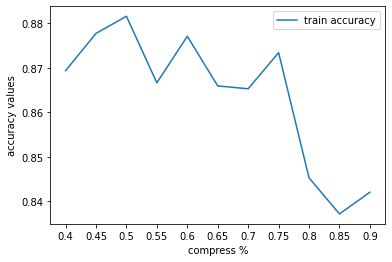

Performing initial model training
Training Progress: Epoch [ 1/25] | Step [  0/391] | Loss: 2.298684 | Top1: 13.28% | Top5: 50.78% | Elapsed Time: 0.13s
Training Progress: Epoch [ 1/25] | Step [ 39/391] | Loss: 2.272933 | Top1: 14.84% | Top5: 66.41% | Elapsed Time: 2.84s
Training Progress: Epoch [ 1/25] | Step [ 78/391] | Loss: 2.071750 | Top1: 22.66% | Top5: 75.78% | Elapsed Time: 1.99s
Training Progress: Epoch [ 1/25] | Step [117/391] | Loss: 1.637627 | Top1: 34.38% | Top5: 92.19% | Elapsed Time: 1.96s
Training Progress: Epoch [ 1/25] | Step [156/391] | Loss: 1.744919 | Top1: 37.50% | Top5: 84.38% | Elapsed Time: 2.03s
Training Progress: Epoch [ 1/25] | Step [195/391] | Loss: 1.674906 | Top1: 37.50% | Top5: 85.94% | Elapsed Time: 2.01s
Training Progress: Epoch [ 1/25] | Step [234/391] | Loss: 1.419959 | Top1: 47.66% | Top5: 94.53% | Elapsed Time: 2.25s
Training Progress: Epoch [ 1/25] | Step [273/391] | Loss: 1.636927 | Top1: 44.53% | Top5: 85.16% | Elapsed Time: 3.13s
Training Progr

In [ ]:
import time

net_name = "CIFAR10_conv_nn_one_shot_testing"
# Setup trainer
trainer = tp.util.train.NetTrainer(
    train_params=train_params,
    retrain_params=retrain_params,
    train_loader=loader_train,
    test_loader=loader_test,
    valid_loader=loader_s,
    num_gpus=1,
)

test_accuracy = []
train_accuracy = []
compression_list = []
keep_ratio = 0.6 # initial keep ratio

# measure start time
st = time.time()

while keep_ratio > 0:

  compression_list.append(round(1-keep_ratio, 2)) 
  net = Net_With_BN_Dropout(3).to(device)
      
  # wrap net with netHandle
  net = tp.util.net.NetHandle(net, net_name)

  # inital training
  print("Performing initial model training")
  trainer.train(net, n_idx)
  n_idx += 1

  # get a loss handle
  loss_handle = trainer.get_loss_handle()    

  print("\n===========================")
  print("model statistics before pruning")
  print(
      f"The network has {net.size()} parameters and "
      f"{net.flops()} FLOPs."
  )
  print("===========================\n")

  # build ALDS network
  net = tp.ALDSNet(net, loader_s, loss_handle)

  print("Test accuracy after inital training: ", calculate_acc(loader_test, net))

  print("keep ratio: ", keep_ratio)
  # dummy forward action to overcome an ALDS issue
  net.forward(torch.rand(4, 3, 32, 32).to("cuda"))
  # compress the net
  net.compress(keep_ratio=keep_ratio)

  print("\n===========================")
  print("model statistics after pruning")
  print(
      f"The network has {net.size()} parameters and "
      f"{net.flops()} FLOPs."
  )
  print("===========================\n")

  print("Test accuracy after ALDS compression before retrain: ", calculate_acc(loader_test, net))    
      
  trainer.retrain(net, n_idx, keep_ratio, s_idx, r_idx)
  r_idx += 1

  test_acc = calculate_acc(loader_test, net)
  test_accuracy.append(test_acc)
  train_acc = calculate_acc(loader_train, net)
  train_accuracy.append(train_acc)

  print("Test accuracy after ALDS compression after retrain: ", test_acc, "keep_ratio: ", keep_ratio)    

  plot_graph("test accuracy", 'compress %', 'accuracy values', [test_accuracy], ['test accuracy'], 0, compression_list)
  plot_graph("train accuracy", 'compress %', 'accuracy values', [train_accuracy], ['train accuracy'], 0, compression_list)
  
  keep_ratio -= 0.05
  keep_ratio = round(keep_ratio, 2)

# measure the end time
et = time.time()
print("start time: ", st, "end time: ", et, "total time in minutes: ", (et-st)/60)

runtime.unassign()

In [1]:
!pip install torch-pruning # v1.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.0 MB/s eta 0:00:00


In [3]:
!git clone https://github.com/VainF/Torch-Pruning.git

Cloning into 'Torch-Pruning'...
remote: Enumerating objects: 2190, done.
remote: Counting objects: 100% (315/315), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 2190 (delta 212), reused 207 (delta 130), pack-reused 1875
Receiving objects: 100% (2190/2190), 4.36 MiB | 4.67 MiB/s, done.
Resolving deltas: 100% (1400/1400), done.


In [4]:
import torch
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.optim import lr_scheduler


batch_size = 64
num_workers = 4
n_features = 28 * 28
n_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda")
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

cifar10_trainset, cifar10_valset = torch.utils.data.random_split(trainset, 
                         [int(len(trainset)*0.8), int(len(trainset)*0.2)])

loader_train = data.DataLoader(cifar10_trainset, shuffle=True, batch_size=64)
loader_val = data.DataLoader(cifar10_valset, shuffle=True, batch_size=64)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
loader_test = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
import sys, os
from typing import Callable
# sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath(__file__))))

from functools import partial
import argparse
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_pruning as tp

py_file_location = '/content/Torch-Pruning/benchmarks'
sys.path.append(os.path.abspath(py_file_location))

import einops
import registry
import engine.utils as utils






parser = argparse.ArgumentParser()

# For pruning
parser.add_argument('-f')
parser.add_argument("--method", type=str, default=None)
parser.add_argument("--speed-up", type=float, default=2)
parser.add_argument("--max-sparsity", type=float, default=1.0)
parser.add_argument("--soft-keeping-ratio", type=float, default=0.0)
parser.add_argument("--reg", type=float, default=5e-4)
parser.add_argument("--weight-decay", type=float, default=5e-4)

args = parser.parse_args()

def progressive_pruning(pruner, model, speed_up, example_inputs):
    model.eval()
    base_ops, _ = tp.utils.count_ops_and_params(model, example_inputs=example_inputs)
    current_speed_up = 1
    while current_speed_up < speed_up:
        pruner.step()
        pruned_ops, _ = tp.utils.count_ops_and_params(model, example_inputs=example_inputs)
        current_speed_up = float(base_ops) / pruned_ops
    return current_speed_up

def eval(model, test_loader, device=None):
    correct = 0
    total = 0
    loss = 0
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            out = model(data)
            loss += F.cross_entropy(out, target, reduction="sum")
            pred = out.max(1)[1]
            correct += (pred == target).sum()
            total += len(target)
    return (correct / total).item(), (loss / total).item()

def train_model(
    model,
    train_loader,
    test_loader,
    epochs,
    lr,
    lr_decay_milestones,
    lr_decay_gamma=0.1,
    save_as=None,
    
    # For pruning
    weight_decay=5e-4,
    save_state_dict_only=True,
    regularizer=None,
    device=None,
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9,
        weight_decay=weight_decay if regularizer is None else 0.0,
    )
    milestones = [int(ms) for ms in lr_decay_milestones.split(",")]
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=milestones, gamma=lr_decay_gamma
    )
    model.to(device)
    best_acc = -1
    for epoch in range(epochs):
        model.train()
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.cross_entropy(out, target)
            loss.backward()
            if regularizer is not None:
                regularizer(model) # for sparsity learning
            optimizer.step()
            if i % 10 == 0 and args.verbose:
                args.logger.info(
                    "Epoch {:d}/{:d}, iter {:d}/{:d}, loss={:.4f}, lr={:.4f}".format(
                        epoch,
                        epochs,
                        i,
                        len(train_loader),
                        loss.item(),
                        optimizer.param_groups[0]["lr"],
                    )
                )
        
        model.eval()
        acc, val_loss = eval(model, test_loader, device=device)
        args.logger.info(
            "Epoch {:d}/{:d}, Acc={:.4f}, Val Loss={:.4f}, lr={:.4f}".format(
                epoch, epochs, acc, val_loss, optimizer.param_groups[0]["lr"]
            )
        )
        if best_acc < acc:
            os.makedirs(args.output_dir, exist_ok=True)
            if args.mode == "prune":
                if save_as is None:
                    save_as = os.path.join( args.output_dir, "{}_{}_{}.pth".format(args.dataset, args.model, args.method) )

                if save_state_dict_only:
                    torch.save(model.state_dict(), save_as)
                else:
                    torch.save(model, save_as)
            elif args.mode == "pretrain":
                if save_as is None:
                    save_as = os.path.join( args.output_dir, "{}_{}.pth".format(args.dataset, args.model) )
                torch.save(model.state_dict(), save_as)
            best_acc = acc
        scheduler.step()
    args.logger.info("Best Acc=%.4f" % (best_acc))

In [7]:
import torch
from torchvision.models import resnet18
import torch_pruning as tp

model = resnet18(pretrained=True)

# Importance criteria
example_inputs = torch.randn(1, 3, 224, 224)
imp = tp.importance.MagnitudeImportance(p=2)

ignored_layers = []
for m in model.modules():
    if isinstance(m, torch.nn.Linear) and m.out_features == 1000:
        ignored_layers.append(m) # DO NOT prune the final classifier!

iterative_steps = 5 # progressive pruning
pruner = tp.pruner.MagnitudePruner(
    model,
    example_inputs,
    importance=imp,
    iterative_steps=iterative_steps,
    ch_sparsity=0.5, # remove 50% channels, ResNet18 = {64, 128, 256, 512} => ResNet18_Half = {32, 64, 128, 256}
    ignored_layers=ignored_layers,
)

base_macs, base_nparams = tp.utils.count_ops_and_params(model, example_inputs)
for i in range(5):
    pruner.step()
    macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
    # finetune your model here
    # train_acc_list, val_acc_list, test_acc_list, epoch_stopped, best_model = run_train(model)
    # ...

SyntaxError: ignored

In [13]:
import sys, os
from typing import Callable
# sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath(__file__))))

from functools import partial
import argparse
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_pruning as tp

py_file_location = '/content/Torch-Pruning/benchmarks'
sys.path.append(os.path.abspath(py_file_location))

import registry
import engine.utils as utils


parser = argparse.ArgumentParser()

# Basic options
parser.add_argument("--mode", type=str, required=True, choices=["pretrain", "prune", "test"])
parser.add_argument("--model", type=str, required=True)
parser.add_argument("--verbose", action="store_true", default=False)
parser.add_argument("--dataset", type=str, default="cifar100", choices=['cifar10', 'cifar100', 'modelnet40'])
parser.add_argument("--batch-size", type=int, default=128)
parser.add_argument("--total-epochs", type=int, default=100)
parser.add_argument("--lr-decay-milestones", default="60,80", type=str, help="milestones for learning rate decay")
parser.add_argument("--lr-decay-gamma", default=0.1, type=float)
parser.add_argument("--lr", default=0.01, type=float, help="learning rate")
parser.add_argument("--restore", type=str, default=None)
parser.add_argument('--output-dir', default='run', help='path where to save')

# For pruning
parser.add_argument("--method", type=str, default=None)
parser.add_argument("--speed-up", type=float, default=2)
parser.add_argument("--max-sparsity", type=float, default=1.0)
parser.add_argument("--soft-keeping-ratio", type=float, default=0.0)
parser.add_argument("--reg", type=float, default=5e-4)
parser.add_argument("--weight-decay", type=float, default=5e-4)

parser.add_argument("--seed", type=int, default=None)
parser.add_argument("--global-pruning", action="store_true", default=False)
parser.add_argument("--sl-total-epochs", type=int, default=100, help="epochs for sparsity learning")
parser.add_argument("--sl-lr", default=0.01, type=float, help="learning rate for sparsity learning")
parser.add_argument("--sl-lr-decay-milestones", default="60,80", type=str, help="milestones for sparsity learning")
parser.add_argument("--sl-reg-warmup", type=int, default=0, help="epochs for sparsity learning")
#parser.add_argument("--sl_restore", type=str, default=None)
parser.add_argument("--sl-restore", action="store_true", default=False)
parser.add_argument("--iterative-steps", default=400, type=int)

parser.add_argument('-f') # dummy run

args = parser.parse_args()

def progressive_pruning(pruner, model, speed_up, example_inputs):
    model.eval()
    base_ops, _ = tp.utils.count_ops_and_params(model, example_inputs=example_inputs)
    current_speed_up = 1
    while current_speed_up < speed_up:
        pruner.step()
        pruned_ops, _ = tp.utils.count_ops_and_params(model, example_inputs=example_inputs)
        current_speed_up = float(base_ops) / pruned_ops
    return current_speed_up

def eval(model, test_loader, device=None):
    correct = 0
    total = 0
    loss = 0
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            out = model(data)
            loss += F.cross_entropy(out, target, reduction="sum")
            pred = out.max(1)[1]
            correct += (pred == target).sum()
            total += len(target)
    return (correct / total).item(), (loss / total).item()

def train_model(
    model,
    train_loader,
    test_loader,
    epochs,
    lr,
    lr_decay_milestones,
    lr_decay_gamma=0.1,
    save_as=None,
    
    # For pruning
    weight_decay=5e-4,
    save_state_dict_only=True,
    regularizer=None,
    device=None,
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9,
        weight_decay=weight_decay if regularizer is None else 0.0,
    )
    milestones = [int(ms) for ms in lr_decay_milestones.split(",")]
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=milestones, gamma=lr_decay_gamma
    )
    model.to(device)
    best_acc = -1
    for epoch in range(epochs):
        model.train()
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.cross_entropy(out, target)
            loss.backward()
            if regularizer is not None:
                regularizer(model) # for sparsity learning
            optimizer.step()
            if i % 10 == 0 and args.verbose:
                args.logger.info(
                    "Epoch {:d}/{:d}, iter {:d}/{:d}, loss={:.4f}, lr={:.4f}".format(
                        epoch,
                        epochs,
                        i,
                        len(train_loader),
                        loss.item(),
                        optimizer.param_groups[0]["lr"],
                    )
                )
        
        model.eval()
        acc, val_loss = eval(model, test_loader, device=device)
        args.logger.info(
            "Epoch {:d}/{:d}, Acc={:.4f}, Val Loss={:.4f}, lr={:.4f}".format(
                epoch, epochs, acc, val_loss, optimizer.param_groups[0]["lr"]
            )
        )
        if best_acc < acc:
            os.makedirs(args.output_dir, exist_ok=True)
            if args.mode == "prune":
                if save_as is None:
                    save_as = os.path.join( args.output_dir, "{}_{}_{}.pth".format(args.dataset, args.model, args.method) )

                if save_state_dict_only:
                    torch.save(model.state_dict(), save_as)
                else:
                    torch.save(model, save_as)
            elif args.mode == "pretrain":
                if save_as is None:
                    save_as = os.path.join( args.output_dir, "{}_{}.pth".format(args.dataset, args.model) )
                torch.save(model.state_dict(), save_as)
            best_acc = acc
        scheduler.step()
    args.logger.info("Best Acc=%.4f" % (best_acc))


def get_pruner(model, example_inputs):
    sparsity_learning = False
    if args.method == "random":
        imp = tp.importance.RandomImportance()
        pruner_entry = partial(tp.pruner.MagnitudePruner, global_pruning=args.global_pruning)
    elif args.method == "l1":
        imp = tp.importance.MagnitudeImportance(p=1)
        pruner_entry = partial(tp.pruner.MagnitudePruner, global_pruning=args.global_pruning)
    elif args.method == "lamp":
        imp = tp.importance.LAMPImportance(p=2)
        pruner_entry = partial(tp.pruner.MagnitudePruner, global_pruning=args.global_pruning)
    elif args.method == "slim":
        sparsity_learning = True
        imp = tp.importance.BNScaleImportance()
        pruner_entry = partial(tp.pruner.BNScalePruner, reg=args.reg, global_pruning=args.global_pruning)
    elif args.method == "group_norm":
        imp = tp.importance.GroupNormImportance(p=2)
        pruner_entry = partial(tp.pruner.GroupNormPruner, global_pruning=args.global_pruning)
    elif args.method == "group_sl":
        sparsity_learning = True
        imp = tp.importance.GroupNormImportance(p=2)
        pruner_entry = partial(tp.pruner.GroupNormPruner, reg=args.reg, global_pruning=args.global_pruning)
    else:
        raise NotImplementedError
    
    #args.is_accum_importance = is_accum_importance
    unwrapped_parameters = []
    args.sparsity_learning = sparsity_learning
    ignored_layers = []
    ch_sparsity_dict = {}
    # ignore output layers
    for m in model.modules():
        if isinstance(m, torch.nn.Linear) and m.out_features == args.num_classes:
            ignored_layers.append(m)
        elif isinstance(m, torch.nn.modules.conv._ConvNd) and m.out_channels == args.num_classes:
            ignored_layers.append(m)
    
    # Here we fix iterative_steps=200 to prune the model progressively with small steps 
    # until the required speed up is achieved.
    pruner = pruner_entry(
        model,
        example_inputs,
        importance=imp,
        iterative_steps=args.iterative_steps,
        ch_sparsity=1.0,
        ch_sparsity_dict=ch_sparsity_dict,
        max_ch_sparsity=args.max_sparsity,
        ignored_layers=ignored_layers,
        unwrapped_parameters=unwrapped_parameters,
    )
    return pruner


def main():
    if args.seed is not None:
        torch.manual_seed(args.seed)

    # Logger
    if args.mode == "prune":
        prefix = 'global' if args.global_pruning else 'local'
        logger_name = "{}-{}-{}-{}".format(args.dataset, prefix, args.method, args.model)
        args.output_dir = os.path.join(args.output_dir, args.dataset, args.mode, logger_name)
        log_file = "{}/{}.txt".format(args.output_dir, logger_name)
    elif args.mode == "pretrain":
        args.output_dir = os.path.join(args.output_dir, args.dataset, args.mode)
        logger_name = "{}-{}".format(args.dataset, args.model)
        log_file = "{}/{}.txt".format(args.output_dir, logger_name)
    elif args.mode == "test":
        log_file = None
    args.logger = utils.get_logger(logger_name, output=log_file)

    # Model & Dataset
    args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes, train_dst, val_dst, input_size = registry.get_dataset(
        args.dataset, data_root="data"
    )
    args.num_classes = num_classes
    model = registry.get_model(args.model, num_classes=num_classes, pretrained=True, target_dataset=args.dataset)
    train_loader = torch.utils.data.DataLoader(
        train_dst,
        batch_size=args.batch_size,
        num_workers=4,
        drop_last=True,
        shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        val_dst, batch_size=args.batch_size, num_workers=4
    )
    
    for k, v in utils.utils.flatten_dict(vars(args)).items():  # print args
        args.logger.info("%s: %s" % (k, v))

    if args.restore is not None:
        loaded = torch.load(args.restore, map_location="cpu")
        if isinstance(loaded, nn.Module):
            model = loaded
        else:
            model.load_state_dict(loaded)
        args.logger.info("Loading model from {restore}".format(restore=args.restore))
    model = model.to(args.device)


    ######################################################
    # Training / Pruning / Testing
    example_inputs = train_dst[0][0].unsqueeze(0).to(args.device)
    if args.mode == "pretrain":
        ops, params = tp.utils.count_ops_and_params(
            model, example_inputs=example_inputs,
        )
        args.logger.info("Params: {:.2f} M".format(params / 1e6))
        args.logger.info("ops: {:.2f} M".format(ops / 1e6))
        train_model(
            model=model,
            epochs=args.total_epochs,
            lr=args.lr,
            lr_decay_milestones=args.lr_decay_milestones,
            train_loader=train_loader,
            test_loader=test_loader
        )
    elif args.mode == "prune":
        model.eval()
        ori_ops, ori_size = tp.utils.count_ops_and_params(model, example_inputs=example_inputs)
        ori_acc, ori_val_loss = eval(model, test_loader, device=args.device)
        pruner = get_pruner(model, example_inputs=example_inputs)

        # 0. Sparsity Learning
        if args.sparsity_learning:
            reg_pth = "reg_{}_{}_{}_{}.pth".format(args.dataset, args.model, args.method, args.reg)
            reg_pth = os.path.join( os.path.join(args.output_dir, reg_pth) )
            if not args.sl_restore:
                args.logger.info("Regularizing...")
                train_model(
                    model,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    epochs=args.sl_total_epochs,
                    lr=args.sl_lr,
                    lr_decay_milestones=args.sl_lr_decay_milestones,
                    lr_decay_gamma=args.lr_decay_gamma,
                    regularizer=pruner.regularize,
                    save_state_dict_only=True,
                    save_as = reg_pth,
                )
            args.logger.info("Loading sparsity model from {}...".format(reg_pth))
            model.load_state_dict( torch.load( reg_pth, map_location=args.device) )
        
        # 1. Pruning
        model.eval()
        args.logger.info("Pruning...")
        progressive_pruning(pruner, model, speed_up=args.speed_up, example_inputs=example_inputs)
        del pruner # remove reference
        args.logger.info(model)
        pruned_ops, pruned_size = tp.utils.count_ops_and_params(model, example_inputs=example_inputs)
        pruned_acc, pruned_val_loss = eval(model, test_loader, device=args.device)
        
        args.logger.info(
            "Params: {:.2f} M => {:.2f} M ({:.2f}%)".format(
                ori_size / 1e6, pruned_size / 1e6, pruned_size / ori_size * 100
            )
        )
        args.logger.info(
            "FLOPs: {:.2f} M => {:.2f} M ({:.2f}%, {:.2f}X )".format(
                ori_ops / 1e6,
                pruned_ops / 1e6,
                pruned_ops / ori_ops * 100,
                ori_ops / pruned_ops,
            )
        )
        args.logger.info("Acc: {:.4f} => {:.4f}".format(ori_acc, pruned_acc))
        args.logger.info(
            "Val Loss: {:.4f} => {:.4f}".format(ori_val_loss, pruned_val_loss)
        )
        
        # 2. Finetuning
        args.logger.info("Finetuning...")
        train_model(
            model,
            epochs=args.total_epochs,
            lr=args.lr,
            lr_decay_milestones=args.lr_decay_milestones,
            train_loader=train_loader,
            test_loader=test_loader,
            device=args.device,
            save_state_dict_only=False,
        )
    elif args.mode == "test":
        model.eval()
        ops, params = tp.utils.count_ops_and_params(
            model, example_inputs=example_inputs,
        )
        args.logger.info("Params: {:.2f} M".format(params / 1e6))
        args.logger.info("ops: {:.2f} M".format(ops / 1e6))
        acc, val_loss = eval(model, test_loader)
        args.logger.info("Acc: {:.4f} Val Loss: {:.4f}\n".format(acc, val_loss))

if __name__ == "__main__":
    main()


usage: ipykernel_launcher.py [-h] --mode {pretrain,prune,test} --model MODEL
                             [--verbose]
                             [--dataset {cifar10,cifar100,modelnet40}]
                             [--batch-size BATCH_SIZE]
                             [--total-epochs TOTAL_EPOCHS]
                             [--lr-decay-milestones LR_DECAY_MILESTONES]
                             [--lr-decay-gamma LR_DECAY_GAMMA] [--lr LR]
                             [--restore RESTORE] [--output-dir OUTPUT_DIR]
                             [--method METHOD] [--speed-up SPEED_UP]
                             [--max-sparsity MAX_SPARSITY]
                             [--soft-keeping-ratio SOFT_KEEPING_RATIO]
                             [--reg REG] [--weight-decay WEIGHT_DECAY]
                             [--seed SEED] [--global-pruning]
                             [--sl-total-epochs SL_TOTAL_EPOCHS]
                             [--sl-lr SL_LR]
                             [--sl

SystemExit: ignored